# Library

In [ ]:
!pip install -r requirements.txt

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import tensorflow as tf
from imblearn import over_sampling
from joblib import dump, load
from scipy.stats import chi2_contingency
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

tf.random.set_seed(24)
shap.initjs()

# Importing Data

In [2]:
!gdown --id 1nn7kCgyManm3pz4p4pOnZRDyYBLx2ujo

In [3]:
df = pd.read_csv("Travel.csv")

# Stage 0

## Data Understanding

### Problem:
Perusahaan 'Trips & Travel.Com' menawarkan lima jenis produk kepada pelanggan mereka, yaitu Paket Basic, Standard, Deluxe, Super Deluxe, dan King. Namun, berdasarkan data tahun lalu, terlihat tingkat konversi yang rendah, dimana hanya 18% dari pelanggan yang membeli paket yang ditawarkan. Perusahaan belum memanfaatkan informasi yang tersedia dari pelanggan dalam menawarkan produk dan menghubungi pelanggan secara  acak, sehingga biaya marketing menjadi tidak efisien.

### Goal:
Dalam usaha ekspansi user base, perusahaan "Trips & Travel.Com" berencana menawarkan produk baru yaitu Wellness Tourism Package. Dalam meluncurkan produk baru, perusahaan ingin:
* Meningkatkan conversion rate dari penawaran produk baru tersebut.
* Membuat biaya marketing menjadi lebih efisien.

### Objectives:
* Membuat model yang dapat memprediksi pelanggan yang berpotensi membeli paket baru.
* Mengidentifikasi segmentasi pelanggan yang berpotensi membeli produk baru berdasarkan atribut mereka.

### Business Metrics:
* Conversion Rate: Persentase dari pelanggan yang ditawarkan yang akhirnya membeli produk tersebut.
* ROI (Return on Investment): Rasio dari nilai keuntungan terhadap biaya marketing.

# Stage 1

## Defining numerical and categorical column

In [4]:
num_col = [
    "Age",
    "MonthlyIncome",
    "CityTier",
    "NumberOfTrips",
    "NumberOfPersonVisiting",
    "NumberOfChildrenVisiting",
    "DurationOfPitch",
    "NumberOfFollowups",
    "PreferredPropertyStar",
    "PitchSatisfactionScore",
]

cat_col = [
    "Passport",
    "OwnCar",
    "Gender",
    "MaritalStatus",
    "Occupation",
    "Designation",
    "ProductPitched",
]

target = "ProdTaken"

## Descriptive Statistics

In [5]:
df[num_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       4662 non-null   float64
 1   MonthlyIncome             4655 non-null   float64
 2   CityTier                  4888 non-null   int64  
 3   NumberOfTrips             4748 non-null   float64
 4   NumberOfPersonVisiting    4888 non-null   int64  
 5   NumberOfChildrenVisiting  4822 non-null   float64
 6   DurationOfPitch           4637 non-null   float64
 7   NumberOfFollowups         4843 non-null   float64
 8   PreferredPropertyStar     4862 non-null   float64
 9   PitchSatisfactionScore    4888 non-null   int64  
dtypes: float64(7), int64(3)
memory usage: 382.0 KB


In [6]:
df[num_col].describe()

,Age,MonthlyIncome,CityTier,NumberOfTrips,NumberOfPersonVisiting,NumberOfChildrenVisiting,DurationOfPitch,NumberOfFollowups,PreferredPropertyStar,PitchSatisfactionScore
count,4662.000000,4655.000000,4888.000000,4748.000000,4888.000000,4822.000000,4637.000000,4843.000000,4862.000000,4888.000000
mean,37.622265,23619.853491,1.654255,3.236521,2.905074,1.187267,15.490835,3.708445,3.581037,3.078151
std,9.316387,5380.698361,0.916583,1.849019,0.724891,0.857861,8.519643,1.002509,0.798009,1.365792
min,18.000000,1000.000000,1.000000,1.000000,1.000000,0.000000,5.000000,1.000000,3.000000,1.000000
25%,31.000000,20346.000000,1.000000,2.000000,2.000000,1.000000,9.000000,3.000000,3.000000,2.000000
50%,36.000000,22347.000000,1.000000,3.000000,3.000000,1.000000,13.000000,4.000000,3.000000,3.000000
75%,44.000000,25571.000000,3.000000,4.000000,3.000000,2.000000,20.000000,4.000000,4.000000,4.000000
max,61.000000,98678.000000,3.000000,22.000000,5.000000,3.000000,127.000000,6.000000,5.000000,5.000000


In [7]:
df[cat_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Passport        4888 non-null   int64 
 1   OwnCar          4888 non-null   int64 
 2   Gender          4888 non-null   object
 3   MaritalStatus   4888 non-null   object
 4   Occupation      4888 non-null   object
 5   Designation     4888 non-null   object
 6   ProductPitched  4888 non-null   object
dtypes: int64(2), object(5)
memory usage: 267.4+ KB


In [8]:
df[cat_col].astype(str).describe()

,Passport,OwnCar,Gender,MaritalStatus,Occupation,Designation,ProductPitched
count,4888,4888,4888,4888,4888,4888,4888
unique,2,2,3,4,4,5,5
top,0,1,Male,Married,Salaried,Executive,Basic
freq,3466,3032,2916,2340,2368,1842,1842


In [9]:
for col in cat_col:
    uniq = df[col].astype(str).unique().tolist()
    print(f"Kolom {col} memiliki {len(uniq)} unique Value(s): {', '.join(uniq)}")

Kolom Passport memiliki 2 unique Value(s): 1, 0
Kolom OwnCar memiliki 2 unique Value(s): 1, 0
Kolom Gender memiliki 3 unique Value(s): Female, Male, Fe Male
Kolom MaritalStatus memiliki 4 unique Value(s): Single, Divorced, Married, Unmarried
Kolom Occupation memiliki 4 unique Value(s): Salaried, Free Lancer, Small Business, Large Business
Kolom Designation memiliki 5 unique Value(s): Manager, Executive, Senior Manager, AVP, VP
Kolom ProductPitched memiliki 5 unique Value(s): Deluxe, Basic, Standard, Super Deluxe, King


In [10]:
df[[target]].astype(str).describe()

,ProdTaken
count,4888
unique,2
top,0
freq,3968


In [11]:
print("Kolom".ljust(26), end="")
print("Jumlah NaN".ljust(23), end="")
print(">20% of total")

for col, nMt, ratio in zip(
    df.columns, df.isna().sum(), df.isna().sum() / len(df) * 100
):
    if nMt != 0:
        print(f"{col}".ljust(30), end="")
        print(f"{nMt}".ljust(25), end="")
        print("Yes") if ratio > 20 else print("No")

Kolom                     Jumlah NaN             >20% of total
Age                           226                      No
TypeofContact                 25                       No
DurationOfPitch               251                      No
NumberOfFollowups             45                       No
PreferredPropertyStar         26                       No
NumberOfTrips                 140                      No
NumberOfChildrenVisiting      66                       No
MonthlyIncome                 233                      No


Insight:
1. Age (Usia):
    * Terdapat 226 missing values, tidak melampaui 20% dari total data
    * Distribusi data mendekati normal dengan mean di 37.6 dan median di 36
    * Usia termuda ada di umur 18
    * Usia tertua ada di 61
2. Monthly Income (Pendapatan bulanan):
    * Terdapat 233 missing values, tidak melampaui 20% dari total data
    * Distribusi data mendekati normal dengan mean di 23619.9$ dan median di 22347$
    * Terdapat beberapa nilai ekstrim yang dapat dilihat dari nilai min yang jauh dari q1 yaitu 1000$ dan nilai max yang jauh dari q3 yaitu 98678$
3. Number Of Trips (Jumlah rerata trip yang dilakukan customer pertahun):
    * Terdapat 140 missing values, tidak melampaui 20% dari total data
    * Distribusi data mendekati normal dengan mean di 3.2 dan median di 3
    * Terdapat beberapa nilai ekstrim yang dapat dilihat dari nilai max yang jauh dari q3 yaitu 22
4. Number of Person Visiting (Jumlah orang dewasa yang ikut trip):
    * Paling umum customer mengajak 2-3 orang dewasa
    * Terdapat juga yang hanya mengajak 1 orang, yang mungkin adalah orang terdekatnya
    * Paling banyak customer pergi bersama 5 orang dewasa lainnya
5. Number of Children Visiting (Jumlah balita yang ikut trip):
    * Terdapat 66 missing values, tidak melampaui 20% dari total data
    * Paling umum customer membawa 1-2 balita
    * Terdapat customer yang sampai membawa 3 balita, namun juga ada yang tidak sama sekali
6. Duration of Pitch (Durasi promosi):
    * Terdapat 251 missing values, tidak melampaui 20% dari total data
    * Distribusi data mendekati normal dengan mean di 15.5 dan median di 13
    * Terdapat beberapa nilai ekstrim yang dapat dilihat dari nilai max yang jauh dari q3 yaitu 127
7. Number of Follow ups (Jumlah tindak lanjut yang dilakukan setelah dilakukannya promosi):
    * Terdapat 45 missing values, tidak melampaui 20% dari total data
    * Distribusi data mendekati normal dengan mean di 3.7 dan median di 4
    * Terdapat paling banyak 6 kali upaya tindak lanjut dan paling sedikit 1
8. Passport (Apakah customer memiliki passport atau tidak):
    * Sebanyak 71% customer tidak memiliki passport
9. Own Car (Apakah customer memiliki mobil atau tidak):
    * Sebanyak 62% customer memiliki mobil
10. Gender (Jenis kelamin customer):
    * Terdapat 3 gender, bisa jadi ini adalah kesalah tulis (typo)
    * Sebanyak 60% customer berjenis kelamin pria
11. Marital Status (Status pernikahan):
    * Terdapat 4 status berbeda
    * Sebanyak 48% customer berstatus menikah
12. City Tier (Tingkat kelayakan kota yang dihuni customer):
    * Terdapat 3 tingkatan kota
    * Sebanyak 65% customer tinggal di kota tingkat 1
13. Occupation (Tipe pekerjaan yang customer jalani):
    * Terdapat 4 tipe pekerjaan
    * Sebanyak 48% customer bekerja sebagai karyawan
14. Designation (Jabatan pekerjaan dari customer):
    * Terdapat 5 jabatan berbeda
    * Sebanyak 38% customer memiliki jabatan eksekutif
15. Preferred Property Star (Preferensi kelas hotel):
    * Terdapat 26 missing values, tidak melampaui 20% dari total data
    * Normalnya ada di range 1-5 tapi pada dataset hanya berkisar dari 3-5.
    * Sebanyak 61% customer memilih untuk menyewa hotel bintang 3
16. Pitch Satisfaction Score (Tingkat/nilai kepuasan customer terhadap promosi yang diberikan):
    * Terdapat 5 tingkatan berbeda yaitu dari 1-5
    * Sebanyak 30% customer memilih memberi nilai 3
17. Product Pitched (Produk yang dikenalkan pada sesi promosi):
    * Terdapat 5 produk berbeda yang memiliki tingkat yang berbeda
    * Sebanyak 38% customer dikenalkan kepada produk Basic
18. Product Taken (Apakah customer mengambil produk yang dikenalkan atau tidak):
    * Sebanyak 81% tidak mengambil produk yang ditawarkan

## Univariate Analysis

In [12]:
label_map = {
    "Designation": {
        "Executive": "1",
        "Manager": "2",
        "Senior Manager": "3",
        "AVP": "4",
        "VP": "5",
    },
    "ProductPitched": {
        "Basic": "1",
        "Standard": "2",
        "Deluxe": "3",
        "Super Deluxe": "4",
        "King": "5",
    },
}

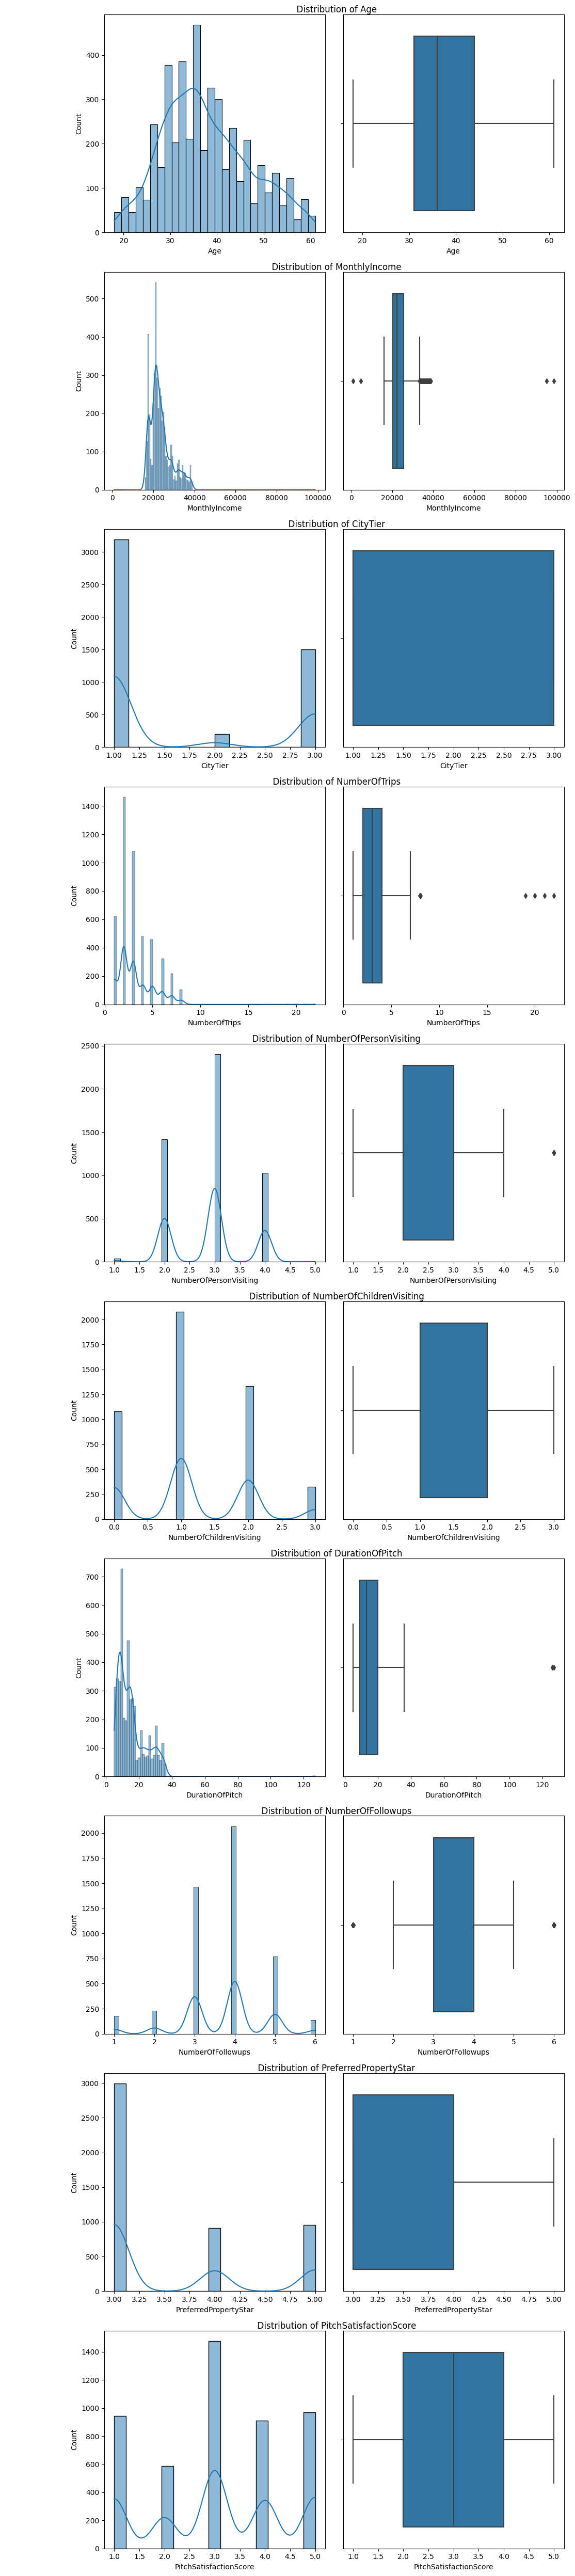

In [13]:
i = 1
plt.figure(figsize=(10, 5 * len(num_col)))
for col in num_col:
    plt.subplot(len(num_col), 2, i)
    sns.histplot(df, x=col, kde=True)
    plt.title(" " * 90 + f"Distribution of {col}", pad=1)
    i += 1
    plt.subplot(len(num_col), 2, i)
    sns.boxplot(df, x=col)
    i += 1
plt.tight_layout()

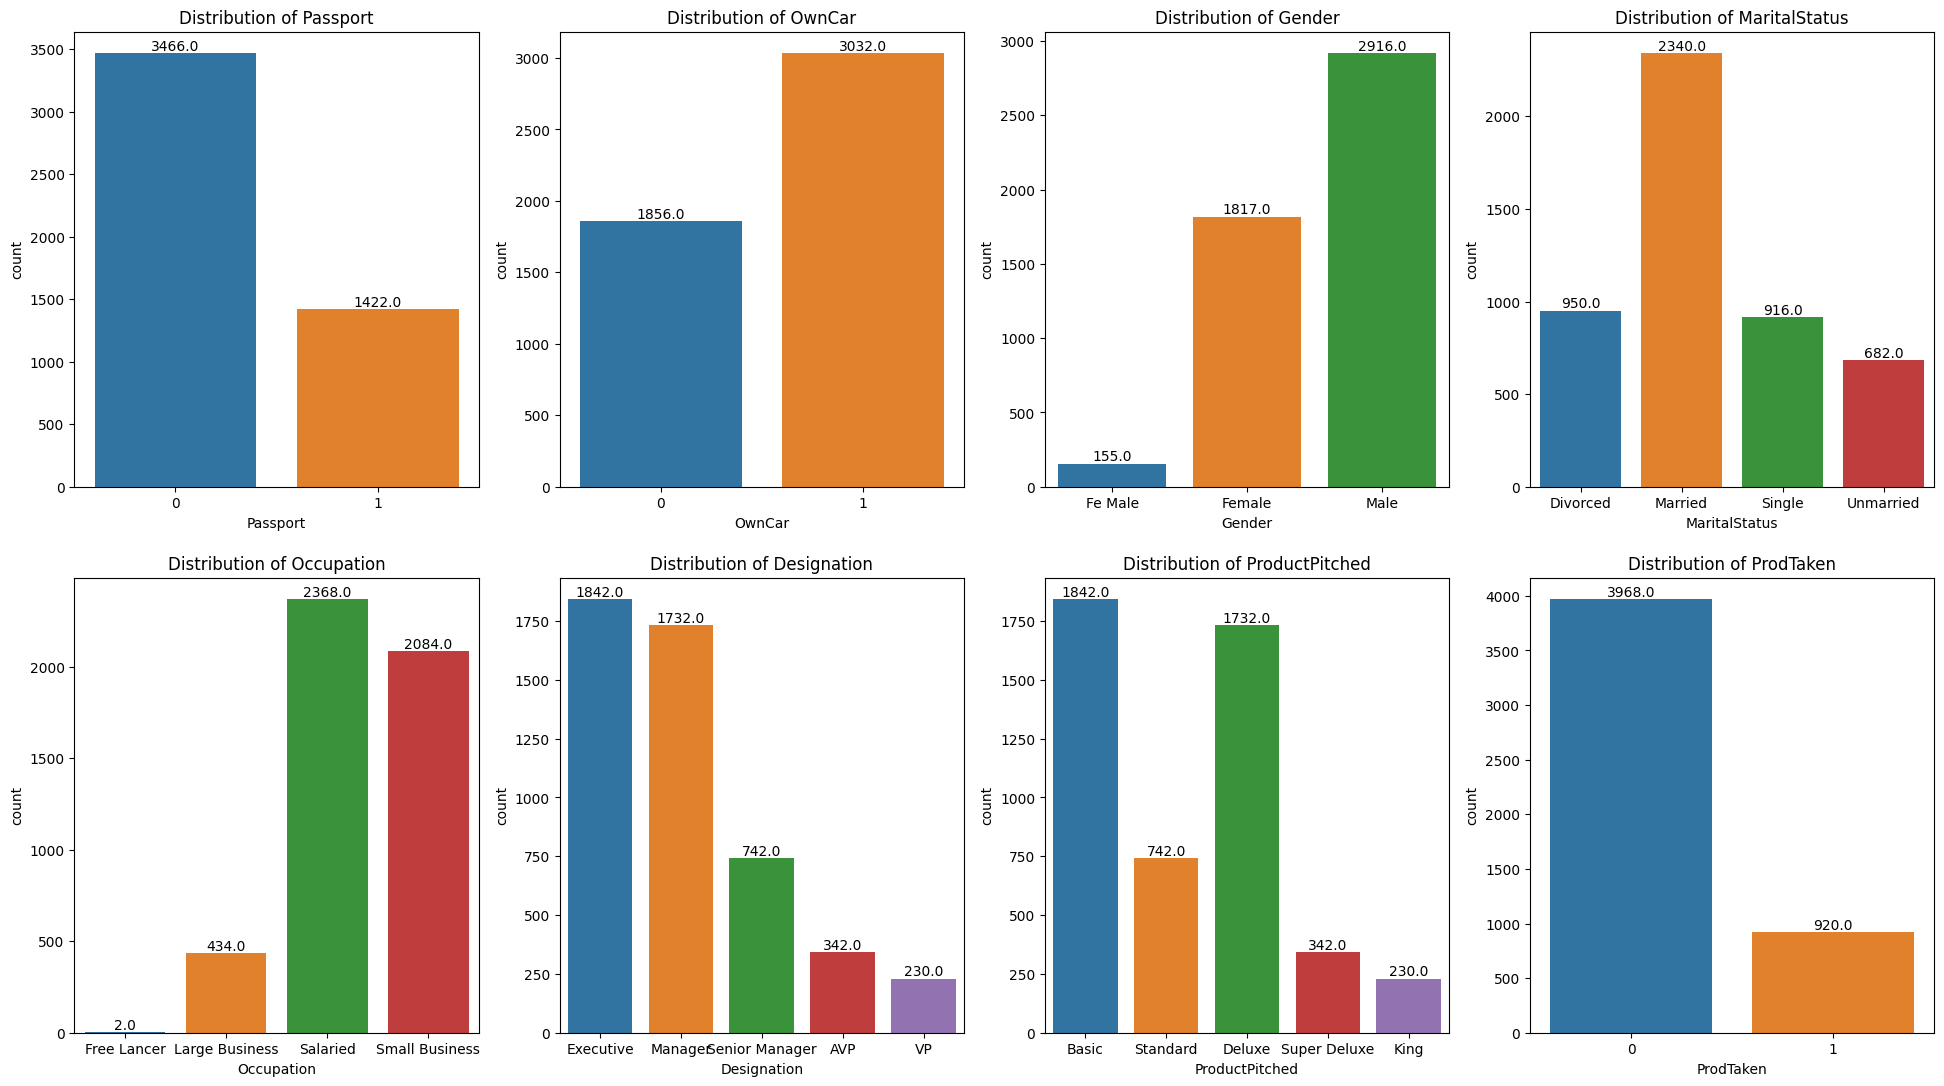

In [14]:
def key(col):
    if col not in label_map:
        return None
    else:
        return lambda x: x.map(label_map[col])


i = 1
plt.figure(figsize=(24, 13))
for col in cat_col + [target]:
    plt.subplot(2, 4, i)
    ax = sns.countplot(df.sort_values(by=col, key=key(col)), x=col)
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height()}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 5),
            textcoords="offset points",
        )
    plt.title(f"Distribution of {col}")
    i += 1
plt.show()

# plt.subplot(122)
# tmp = df.sort_values(by=col, key=key(col))[col].value_counts(sort=False) / len(df)
# ax = sns.barplot(x=tmp.index, y=tmp.values)
# plt.xlabel(col)
# for p in ax.patches:
#     ax.annotate(
#         f"{p.get_height()*100:.0f}%",
#         (p.get_x() + p.get_width() / 2.0, p.get_height()),
#         ha="center",
#         va="center",
#         xytext=(0, 5),
#         textcoords="offset points",
#     )

- ProdTaken = 0 (tidak mengambil produk) jauh lebih banyak
- Sebagian besar pelanggan tidak memiliki Passport
- Lebih banyak pelanggan yang memiliki mobil
- Gender yang paling banyak adalah Male. Ada sejumlah kecil pelanggan yang mencantumkan gendernya sebagai "Fe Male"
- Sebagian besar pelanggan sudah menikah. Jumlah pelanggan yang sudah menikah jauh lebih besar dibandinigkan marital status lainnya (unmarried, divorced, dan single)
- Sebagian besar pelanggan adalah karyawan. Untuk pelanggan yang mempunyai bisnis sendiri, lebih banyak pelanggan yang mempunyai bisnis kecil dibandingkan bisnis besar.
- Jabatan yang paling banyak di adalah Executive, diikuti oleh Manager.
- Produk yang paling sering ditawarkan adalah Basic. Produk yang paling jarang ditawarkan adalah King.


## Multivariate Analysis

Text(0.5, 1.0, 'Numerical Columns Correlation')

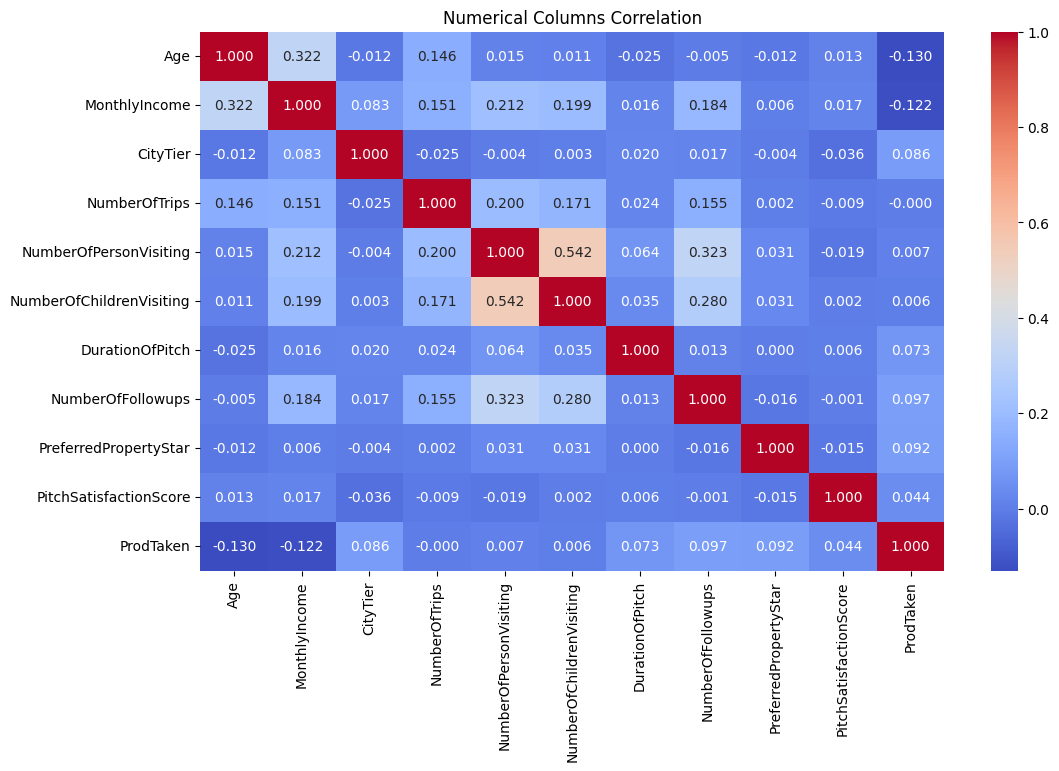

In [15]:
# Melihat korelasi antar kolom numerikal

plt.figure(figsize=(12, 7))
sns.heatmap(
    df[num_col + [target]].corr(method="kendall"),
    annot=True,
    cmap="coolwarm",
    fmt=".3f",
)

plt.title("Numerical Columns Correlation")

In [16]:
# Melihat korelasi antar kolom kategorikal

cat_col_target = cat_col + [target]

p_values_matrix = np.zeros((len(cat_col_target), len(cat_col_target)))
cramers_v_matrix = np.zeros((len(cat_col_target), len(cat_col_target)))

for i in range(len(cat_col_target)):
    for j in range(i + 1, len(cat_col_target)):
        contingency_table = pd.crosstab(df[cat_col_target[i]], df[cat_col_target[j]])
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        n = contingency_table.sum().sum()
        cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

        p_values_matrix[i, j] = p_value
        p_values_matrix[j, i] = p_value
        cramers_v_matrix[i, j] = cramers_v
        cramers_v_matrix[j, i] = cramers_v

p_values_df = pd.DataFrame(
    p_values_matrix, index=cat_col_target, columns=cat_col_target
)
cramers_v_df = pd.DataFrame(
    cramers_v_matrix, index=cat_col_target, columns=cat_col_target
)

Text(0.5, 1.0, 'Chi-Squared Test - Categorical Correlation')

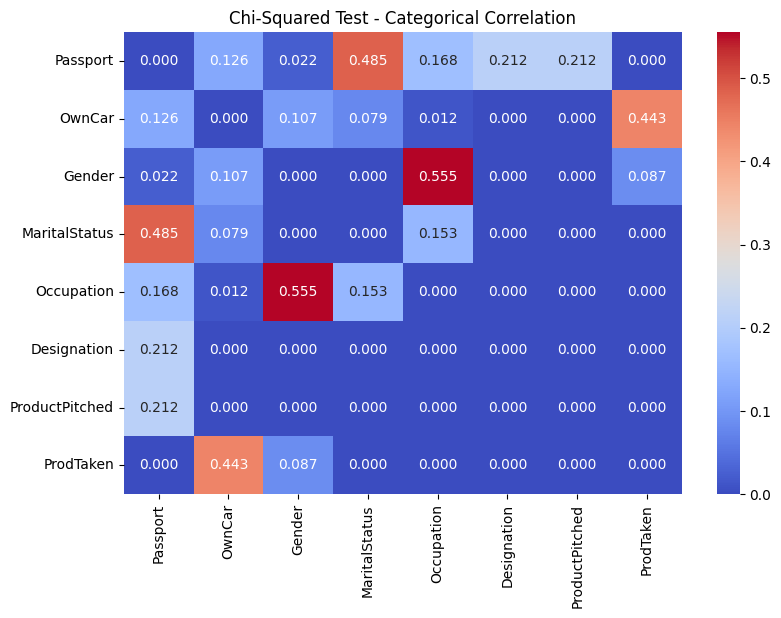

In [17]:
plt.figure(figsize=(9, 6))
sns.heatmap(
    p_values_df,
    annot=True,
    cmap="coolwarm",
    fmt=".3f",
)

plt.title("Chi-Squared Test - Categorical Correlation")

* Chi2 test menunjukkan adanya korelasi apabila p-value nya <= alpha di mana alpha umumnya menggunakan 0.05
* Target variabel (ProdTaken) memiliki korelasi dengan kolom: Passport, MaritalStatus, Occupation, Designation, ProductPitched

Text(0.5, 1.0, "Cramer's V - Categorical Correlation")

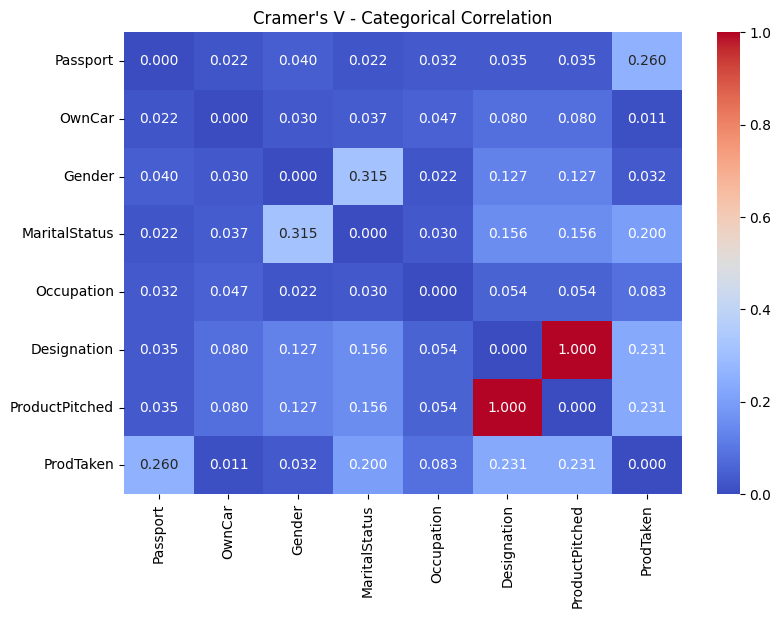

In [18]:
plt.figure(figsize=(9, 6))
sns.heatmap(
    cramers_v_df,
    annot=True,
    cmap="coolwarm",
    fmt=".3f",
)

plt.title("Cramer's V - Categorical Correlation")

* Nilai Cramer’s V berkisar antara 0 (tidak ada korelasi sama sekali) hingga 1 (sangat kuat/dependan)
* Nilai Cramer’s V lebih menggambarkan dibanding dengan Chi2 test yang sebelumnya
* Dengan menggunakan threshold 0.05 sebagai batas nilai bawah, target variabel (ProdTaken) berkorelasi dengan kolom: Passport, MaritalStatus, Occupation, Designation
* Nilai Cramer’s V kolom Designation dengan ProductPitched menunjukkan adanya korelasi yang sangat tinggi (dependan), mendukung hipotesa awal bahwa company telah menargetkan produk tertentu kepada customer dengan jabatan tertentu
* Passport, Marital Status, Designation, dan ProductPitched mempunyai korelasi yang paling tinggi dengan ProdTaken

In [19]:
df_temp = df.copy()
df_temp["ProductPitched"] = df_temp["ProductPitched"].map(
    {"Basic": 1, "Standard": 2, "Deluxe": 3, "Super Deluxe": 4, "King": 5}
)
df_temp["Designation"] = df_temp["Designation"].map(
    {"Executive": 1, "Manager": 2, "Senior Manager": 3, "AVP": 4, "VP": 5}
)

Text(0.5, 1.0, 'Age-MonthlyIncome-Product Correlation')

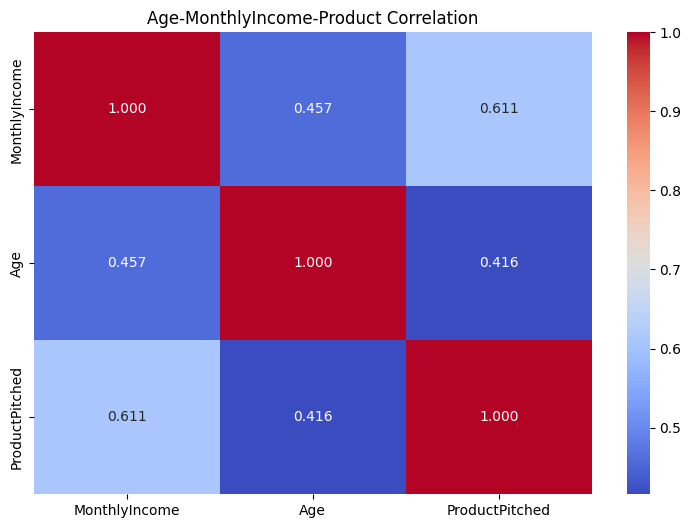

In [20]:
# Melihat seberapa besar korelasi antara pendapatan bulan dengan umur pelanggan

corr = df_temp[["MonthlyIncome", "Age", "ProductPitched"]].corr(method="spearman")
plt.figure(figsize=(9, 6))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".3f",
)

plt.title("Age-MonthlyIncome-Product Correlation")

* Pelanggan yang lebih muda cenderung memiliki pendapatan bulanan yang lebih rendah dibanding dengan pelanggan dengan umur yang lebih tua

In [21]:
# Melihat conversion rate product yang ditawarkan terhadap jabatan berbeda

df.groupby(["Designation", "ProductPitched"])["ProdTaken"].value_counts(
    normalize=True
).unstack().sort_index(key=key("Designation"))

,ProdTaken,0,1
Designation,ProductPitched,,
Executive,Basic,0.700326,0.299674
Manager,Deluxe,0.882217,0.117783
Senior Manager,Standard,0.832884,0.167116
AVP,Super Deluxe,0.941520,0.058480
VP,King,0.913043,0.086957


* Pelanggan dengan jabatan tertentu hanya mendapatkan tawaran produk tertentu

(10000.0, 50000.0)

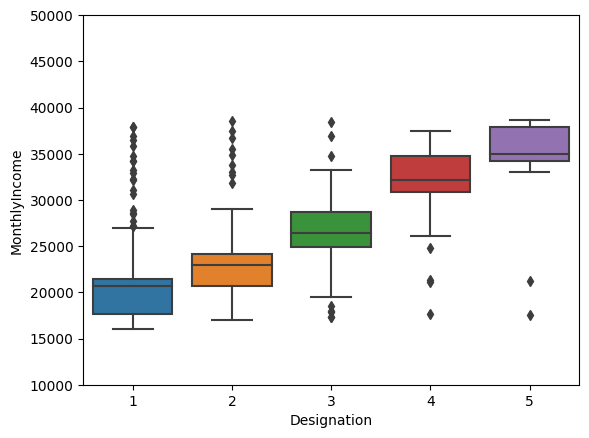

In [22]:
# Melihat distribusi pendapatan bulanan dengan jabatan pelanggan

sns.boxplot(
    df_temp,
    y="MonthlyIncome",
    x="Designation",
)

plt.ylim(10000, 50000)

<AxesSubplot: xlabel='Designation', ylabel='Age'>

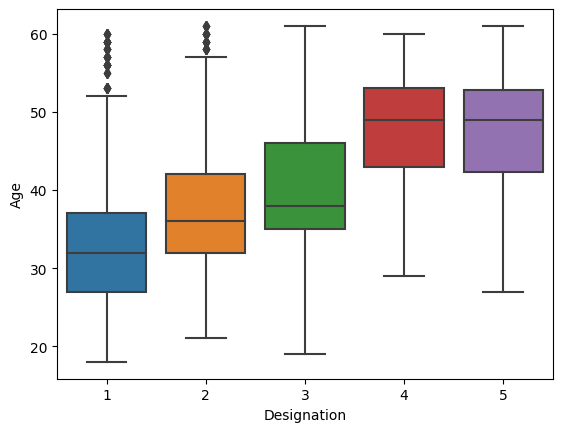

In [23]:
# Melihat distribusi umur dengan jabatan pelanggan

sns.boxplot(
    df_temp,
    y="Age",
    x="Designation",
)

<AxesSubplot: ylabel='Designation'>

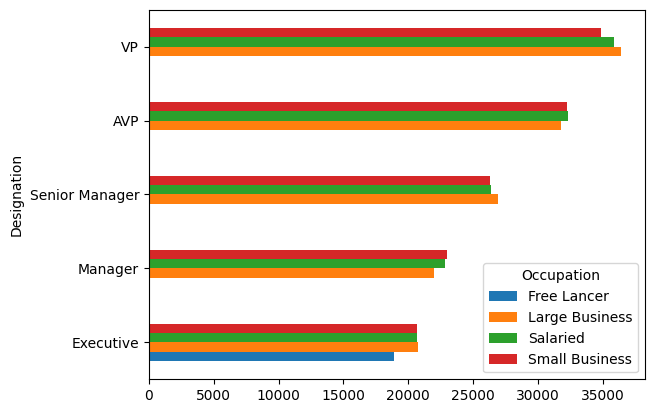

In [24]:
# Melihat apakah ada perbedaan pendapatan di beda cakupan perusahaan

dop = (
    df.groupby(["Designation", "Occupation"])["MonthlyIncome"]
    .median()
    .unstack()
    .sort_index(key=key("Designation"))
)
dop.plot(kind="barh")

* Eksekutif merupakan jabatan dengan hirarki terendah bila dilihat dari pendapatan bulanannya, disusul dengan Manager, Senior Manager, AVP, dan VP
* Pelanggan yang paling muda cenderung memiliki jabatan paling rendah, demikian juga memiliki pendapatan bulanan yang paling rendah
* Sebaliknya, pelanggan yang lebih tua cenderung memiliki jabatan yang lebih tinggi, demikian pula memiliki pendapatan bulanan yang lebih tinggi
* Perusahaan telah menargetkan produk yang paling terjangkau (Basic) hanya kepada pelanggan yang paling muda (sekitar 30 tahun), memiliki jabatan paling rendah (Executive), dan memiliki pendapatan bulanan yang paling rendah (sekitar 20.000\$)
* Sama seperti poin sebelumnya, produk produk lainnya juga disesuaikan hingga produk yang paling mewah (King) diberikan hanya kepada pelanggan yang sudah tua (sekitar 50 tahun), memiliki jabatan yang paling tinggi (VP), dan memiliki pendapatan bulanan yang paling tinggi (sekitar 35.000\$)

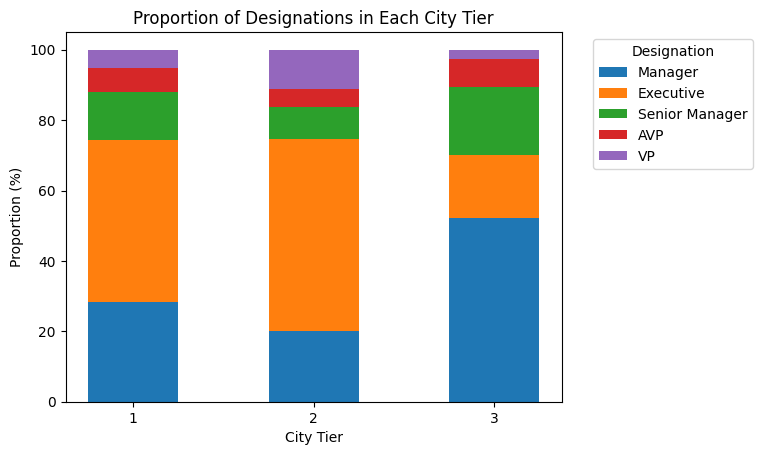

In [25]:
# Melihat jumlah (proporsi) jabatan di setiap city tier

designation_counts = (
    df.groupby(["CityTier", "Designation"]).size().unstack(fill_value=0)
)

unique_designations = df["Designation"].unique()

bar_width = 0.5
index = range(len(designation_counts))

bottom = None

total_counts_per_tier = designation_counts.sum(axis=1)

for i, designation in enumerate(unique_designations):
    proportions = (
        designation_counts[designation] / total_counts_per_tier
    ) * 100  # Calculate proportions
    plt.bar(index, proportions, bar_width, label=designation, bottom=bottom)
    if i == 0:
        bottom = proportions
    else:
        bottom += proportions

plt.xlabel("City Tier")
plt.ylabel("Proportion (%)")
plt.title("Proportion of Designations in Each City Tier")
plt.xticks(index, designation_counts.index)
plt.legend(title="Designation", loc="upper right", bbox_to_anchor=(1.4, 1))

plt.show()

- Mayoritas penduduk mempunyai jabatan Executive
- Ada lebih banyak penduduk yang memiliki Jabatan VP di City Tier 2,
dibandingkan dengan jumlah penduduk kota-kota tersebut (relative proportion)

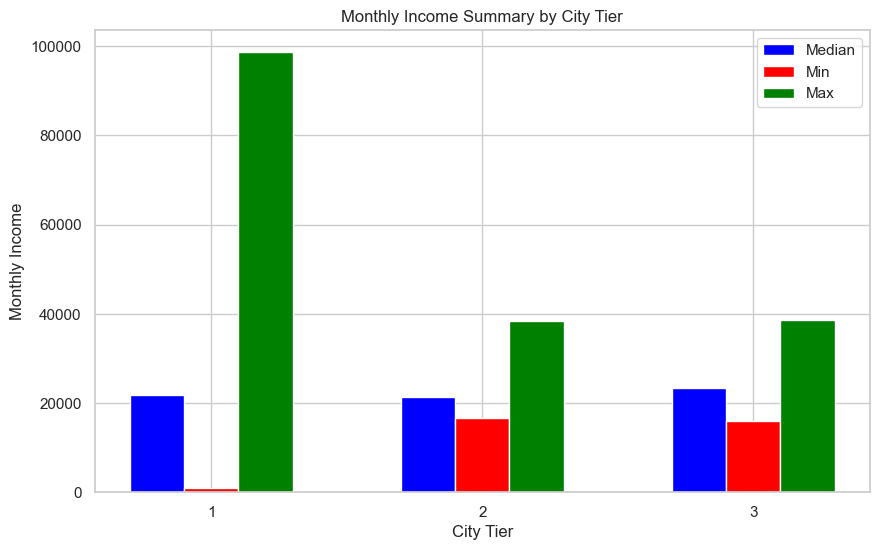

In [26]:
# Melihat median, min, dan max monthly income untuk setiap city tier

income_summary = (
    df.groupby("CityTier")["MonthlyIncome"].agg(["min", "max", "median"]).reset_index()
)

df["MonthlyIncome"]

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

bar_width = 0.2
index = np.arange(len(income_summary["CityTier"]))

plt.bar(
    index - bar_width, income_summary["median"], bar_width, color="blue", label="Median"
)
plt.bar(index, income_summary["min"], bar_width, color="red", label="Min")
plt.bar(index + bar_width, income_summary["max"], bar_width, color="green", label="Max")

plt.xlabel("City Tier")
plt.ylabel("Monthly Income")
plt.title("Monthly Income Summary by City Tier")
plt.xticks(index, income_summary["CityTier"])
plt.legend()

plt.show()

- City Tier 1 mempunyai maximum monthly income yang paling tinggi dan juga minimum monthly income ynag paling rendah
- Monthly Income yang tertinggi ada pada City Tier 1, namun ini dikarenakan adanya outlier di City 1
- Median monthly income ada di kisaran yang sama, walaupun City Tier 3 memiliki median monthly income yang sedikit lebih tinggi

(10000.0, 50000.0)

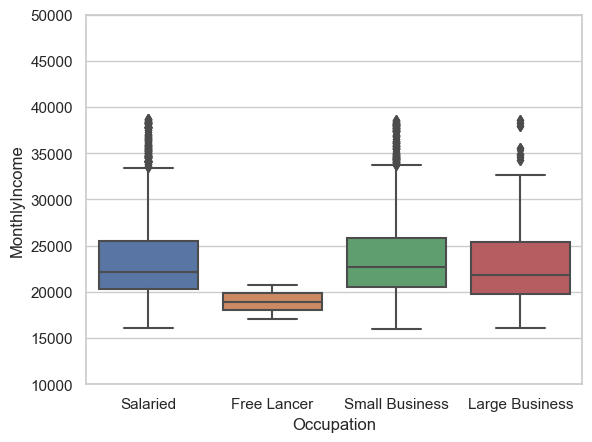

In [27]:
# Melihat distribusi pendapatan bulanan dengan jenis pekerjaan pelanggan

sns.boxplot(
    df,
    y="MonthlyIncome",
    x="Occupation",
)

plt.ylim(10000, 50000)

<AxesSubplot: xlabel='Occupation', ylabel='Age'>

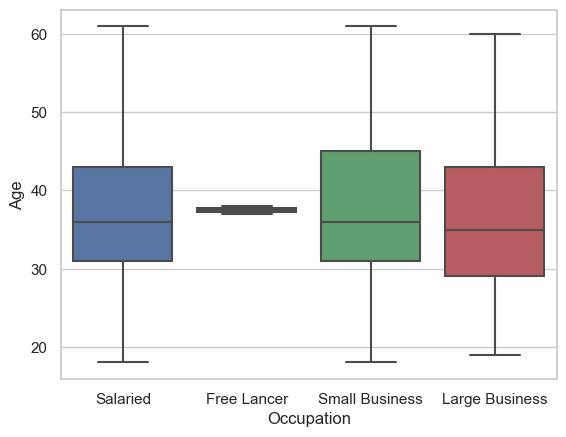

In [28]:
# Melihat distribusi umur dengan jenis pekerjaan pelanggan

sns.boxplot(
    df,
    y="Age",
    x="Occupation",
)

* Tidak ada perbedaan pada distribusi umur maupun pendapatan bulanan dari tiap jenis pekerjaan pelanggan

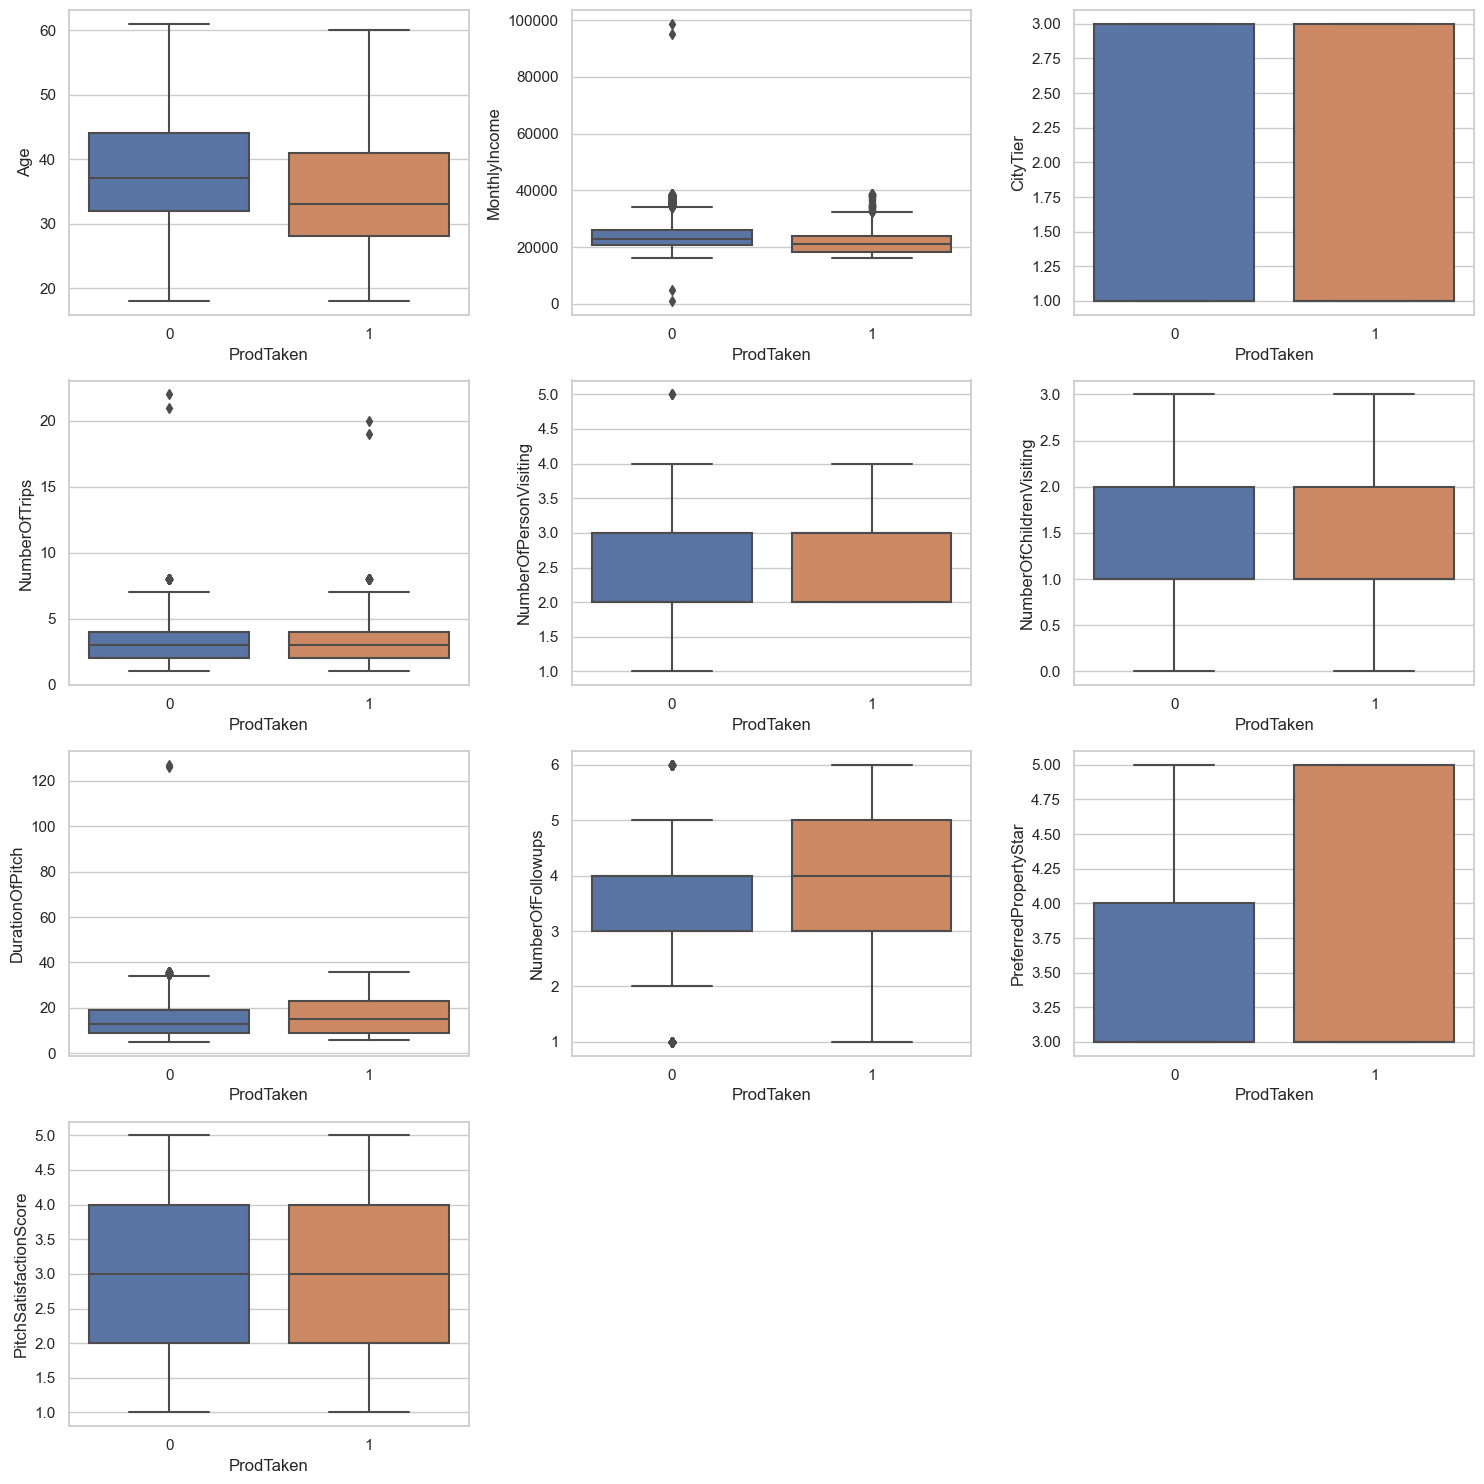

In [29]:
# Melihat conversion rate pada setiap kolom numerikal

plt.figure(figsize=(15, 15))
i = 1
for col in num_col:
    plt.subplot(4, 3, i)
    sns.boxplot(df, x=target, y=col)
    i += 1
plt.tight_layout()

* Distribusi data dari Umur dan Pendapatan Bulanan antara ProdTaken=1 dan ProdTaken=0 mirip, yaitu Umur/Pendapatan Bulanan yang lebih rendah cenderung ProdTaken=1
* Jumlah tindak lanjut yang lebih banyak cenderung mengarah pada customer yang akan mengambil produk
* Mirip dengan jumlah tindak lanjut, durasi promosi yang sedikit lebih lama cenderung mengarah pada customer yang akan mengambil produk

Text(0.5, 1.0, 'Optimum Duration of Pitch')

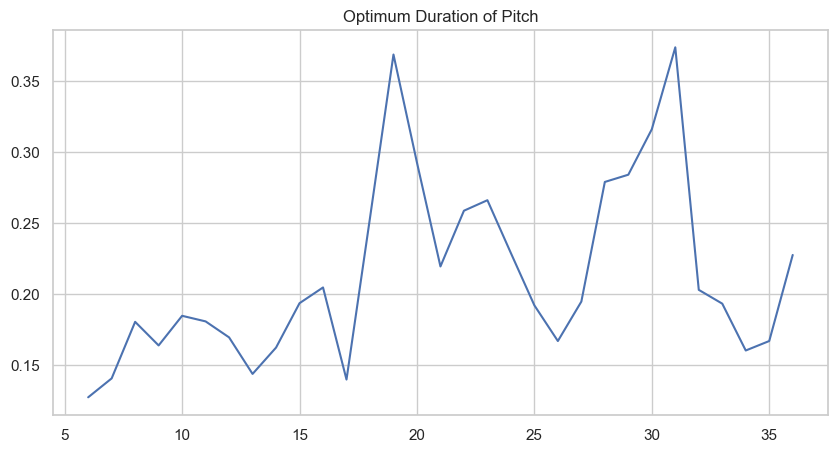

In [30]:
# Melihat durasi optimal dalam menyampaikan promosi
dop = df.groupby("DurationOfPitch")["ProdTaken"].value_counts(normalize=True).unstack()
plt.figure(figsize=(10, 5))
plt.plot(dop.index, dop[1])
plt.title("Optimum Duration of Pitch")

* Durasi paling optimal terdapat pada menit ke 19-20 dan 30-31

<AxesSubplot: xlabel='Passport,ProductPitched'>

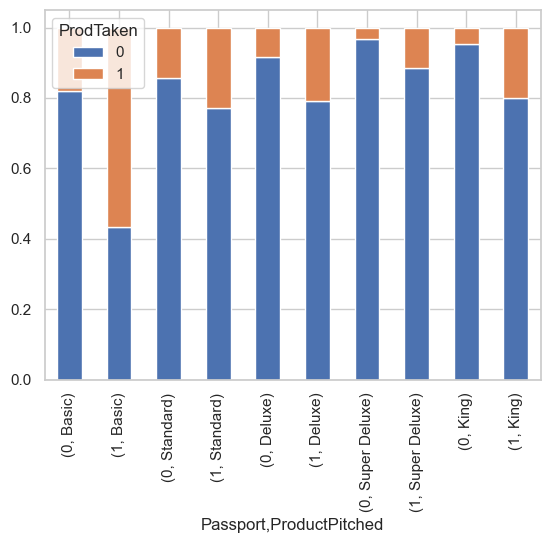

In [31]:
# Melihat apakah produk tertentu eksklusif/butuh passport
pep = (
    df.groupby(["Passport", "ProductPitched"])["ProdTaken"]
    .value_counts(normalize=True)
    .unstack()
    .sort_index(key=key("ProductPitched"))
)
pep.plot(kind="bar", stacked=True)

* Tidak ada produk yang harus memiliki passport

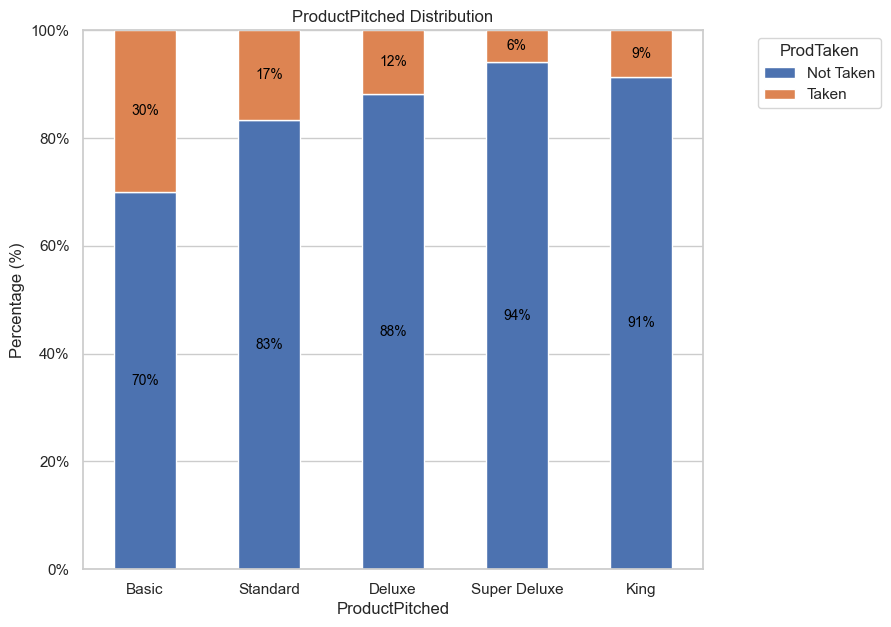

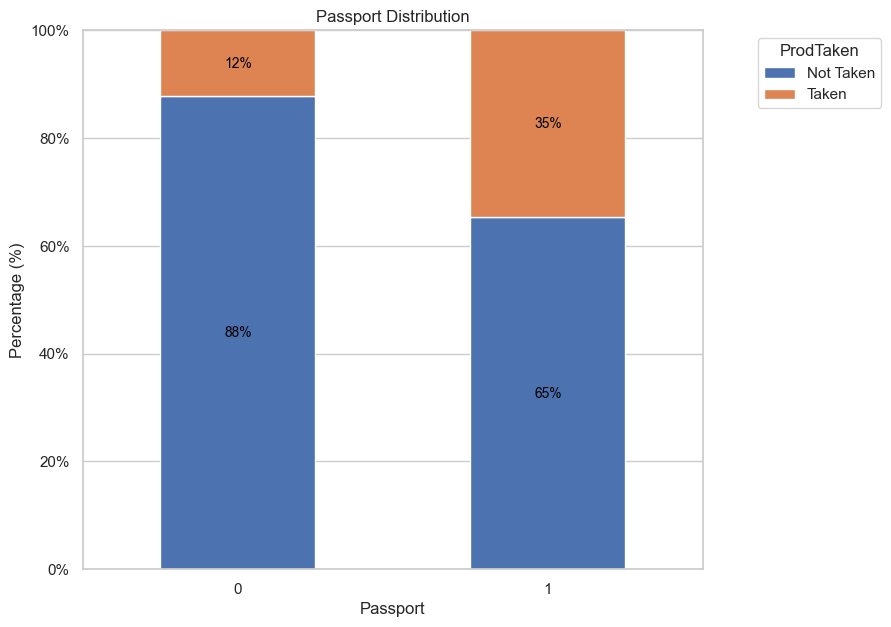

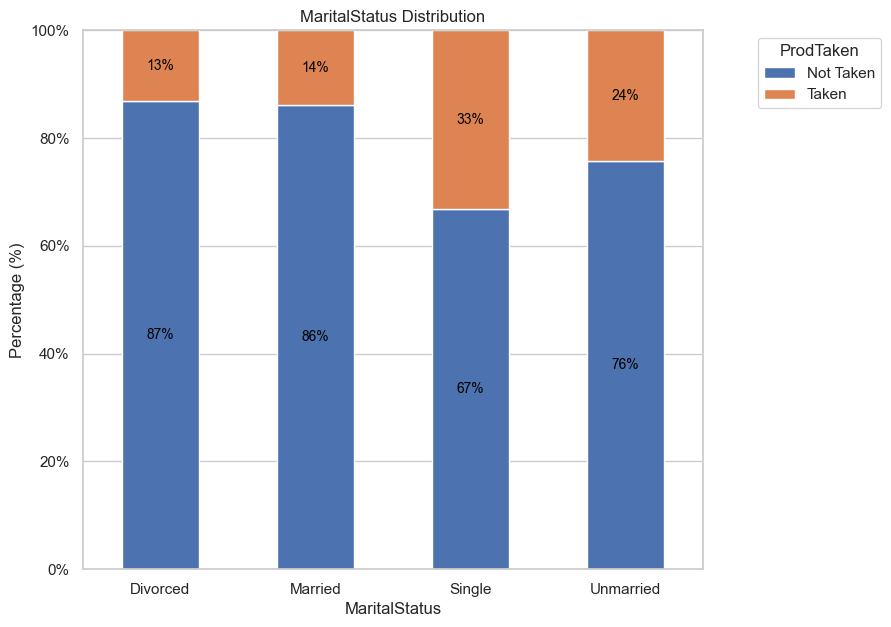

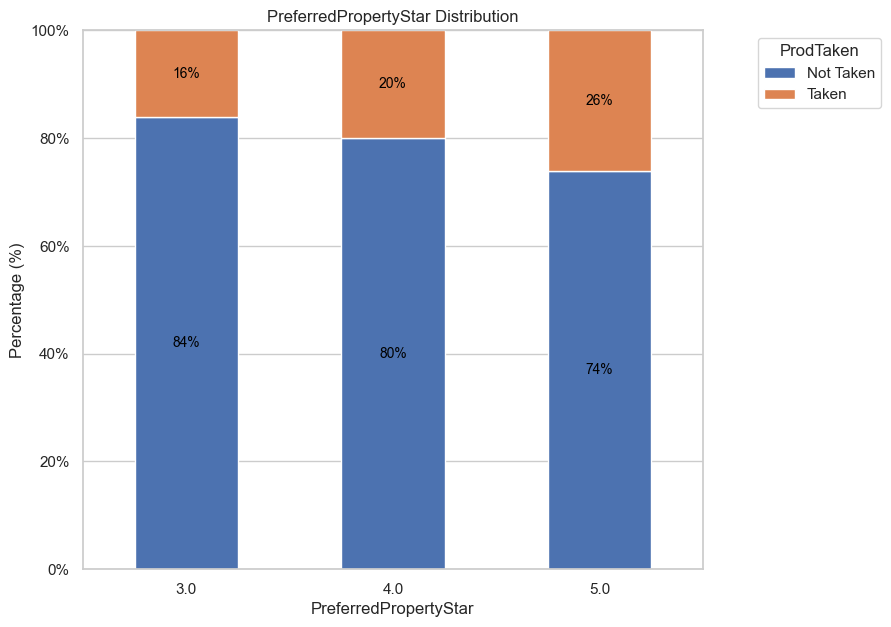

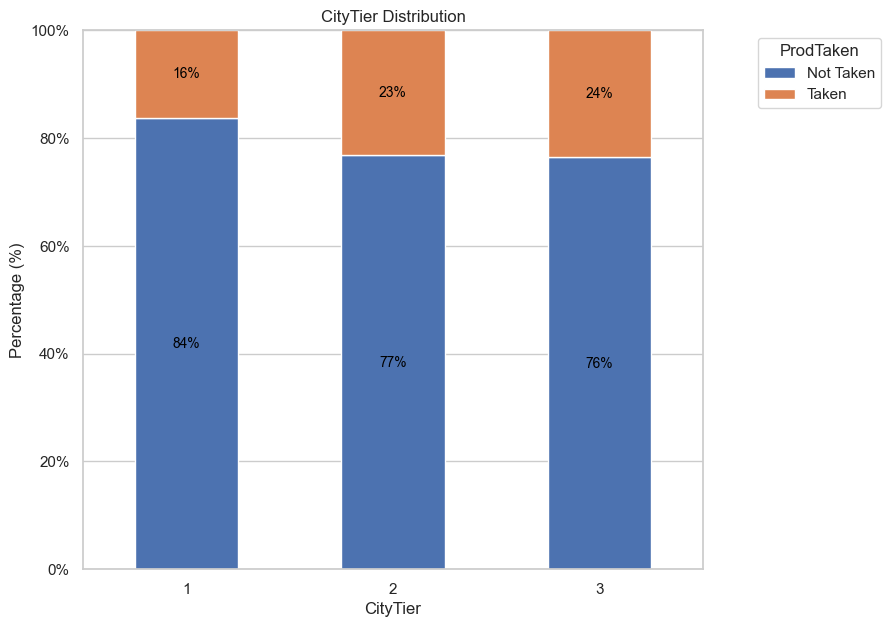

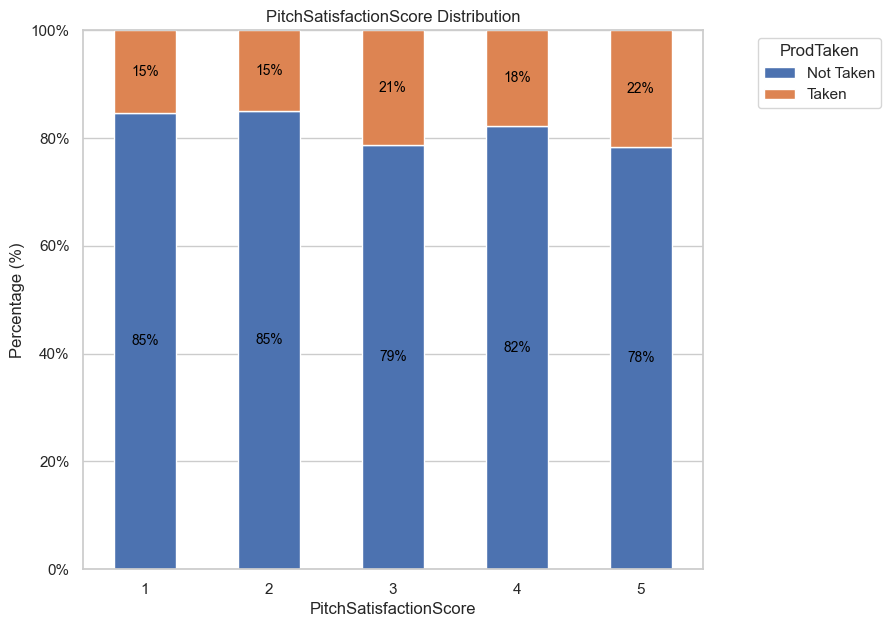

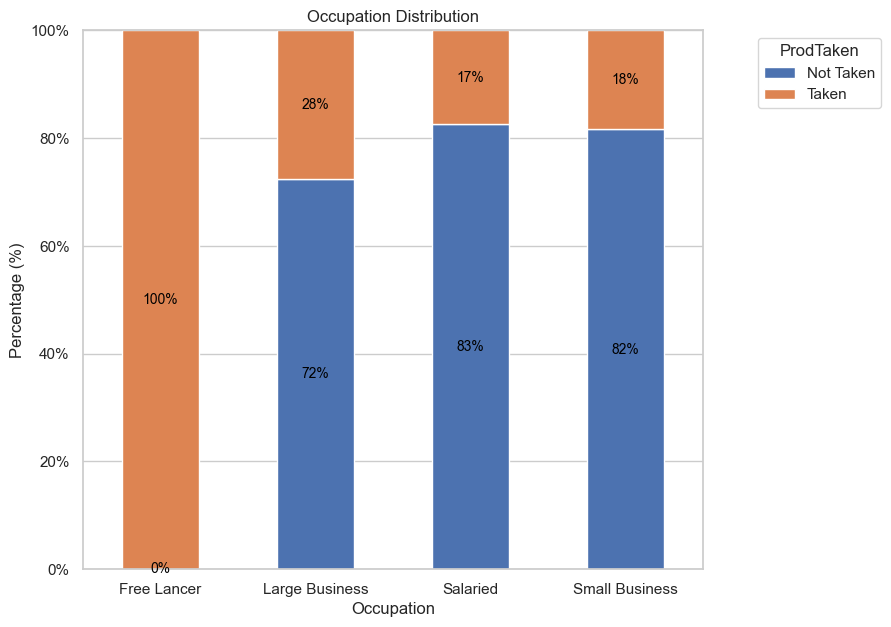

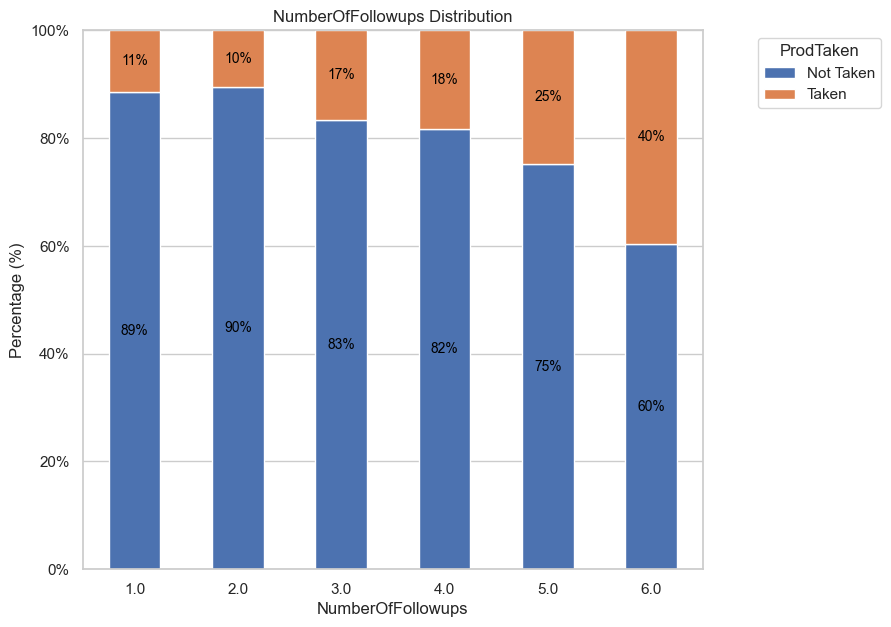

In [32]:
# Define top cat feature based on correlation (highest to lowest)
top_feat = [
    "ProductPitched",
    "Passport",
    "MaritalStatus",
    "PreferredPropertyStar",
    "CityTier",
    "PitchSatisfactionScore",
    "Occupation",
    "NumberOfFollowups",
]

# Melihat conversion rate pada setiap top fitur kategorikal

for col in top_feat:
    ax = (
        df.groupby([col])[target]
        .value_counts(normalize=True)
        .unstack()
        .sort_index(key=key(col))
        .plot(kind="bar", stacked=True, figsize=(8, 7))
    )

    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.annotate(
            f"{height:.0%}",
            (
                x + width / 2,
                y + height / 2,
            ),
            ha="center",
            va="center",
            fontsize=10,
            color="black",
        )
    plt.title(f"{col} Distribution")
    plt.xticks(rotation=0)

    y_ticks = ax.get_yticks()
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f"{y:.0%}" for y in y_ticks])
    plt.ylim(0, 1)

    plt.ylabel("Percentage (%)")
    plt.legend(
        title=target,
        labels=["Not Taken", "Taken"],
        loc="upper right",
        bbox_to_anchor=(1.3, 1),
    )

plt.show()

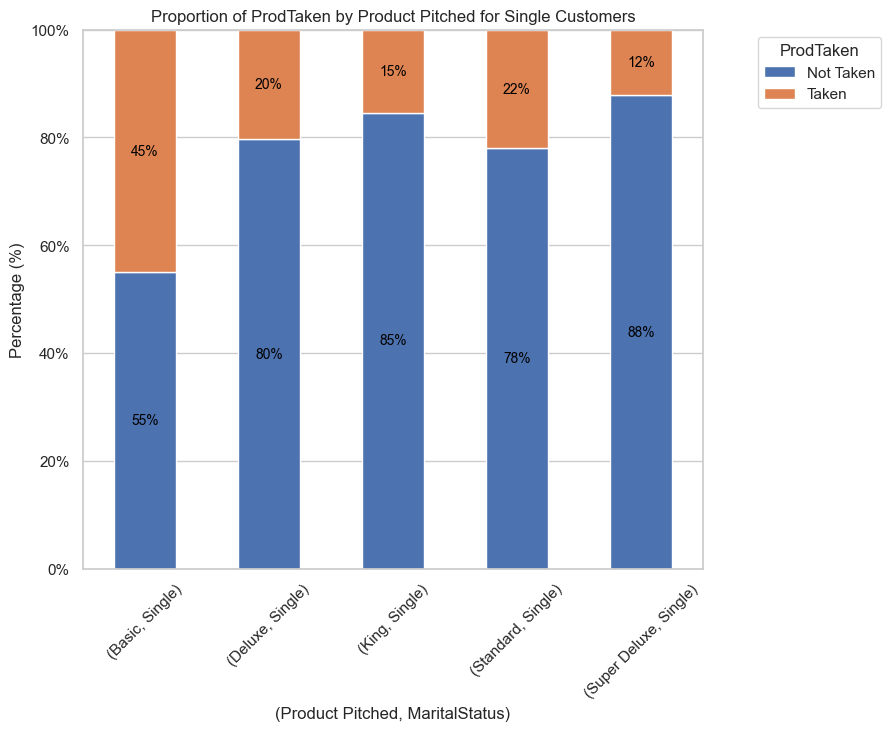

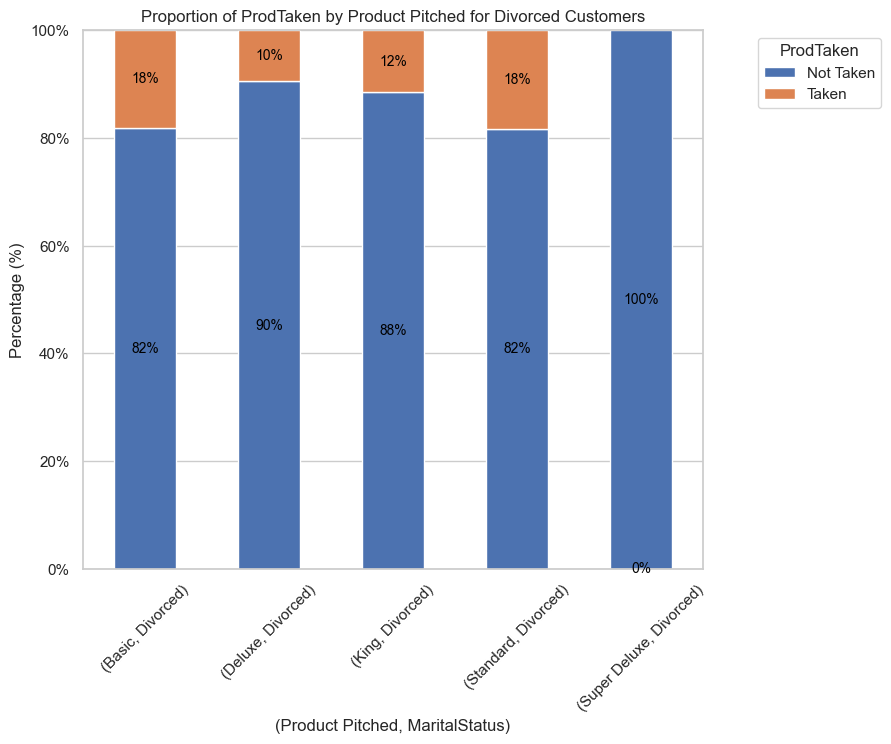

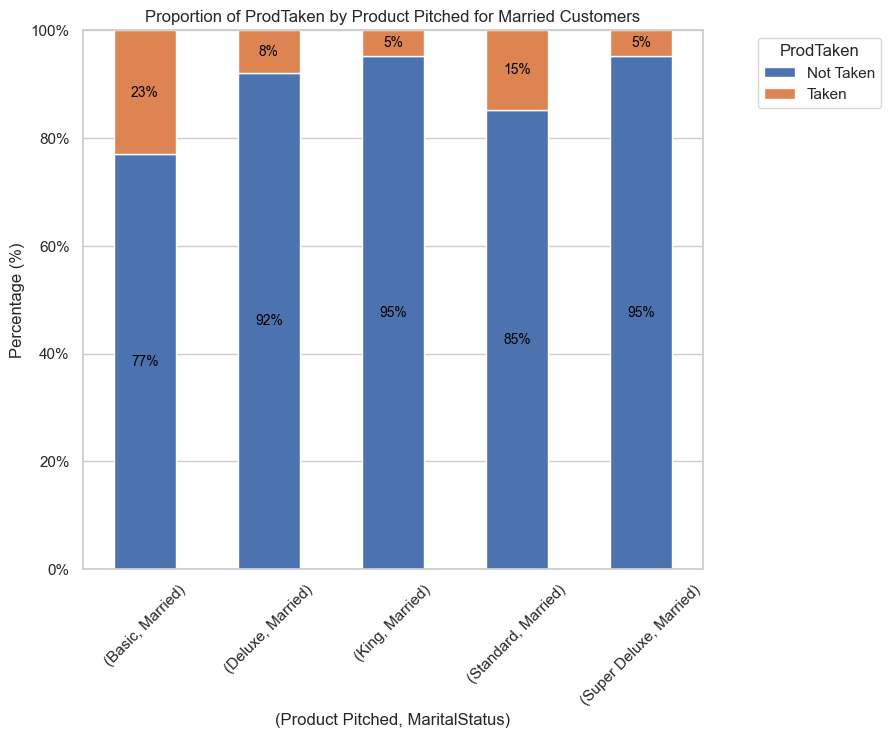

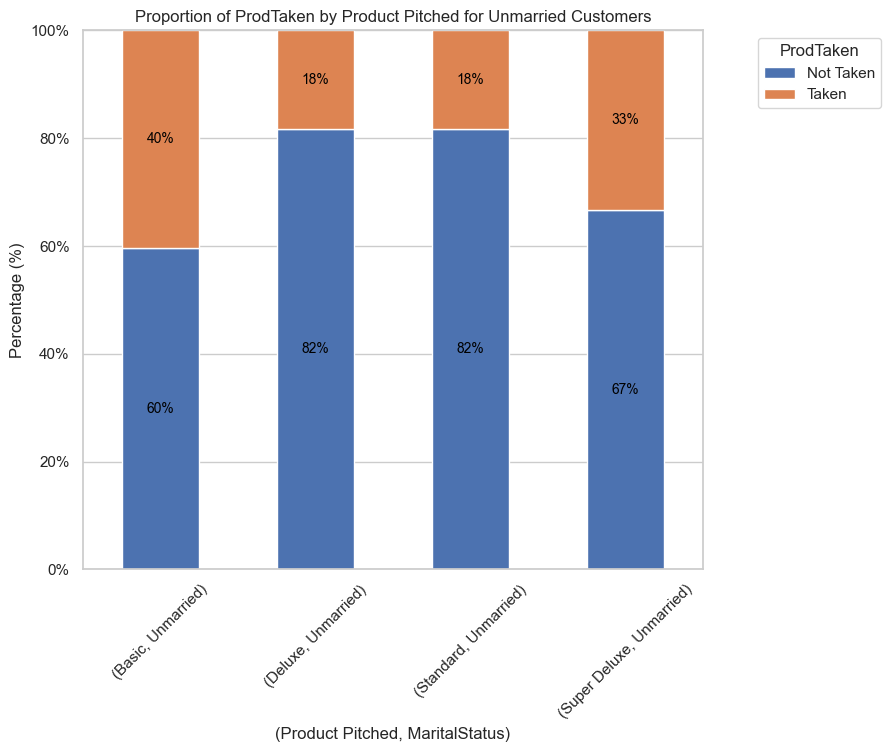

In [33]:
# Melihat conversion rate fitur terhadap produk yang ditawarkan

col = "MaritalStatus"  # @param ['Passport', 'Designation', 'MaritalStatus', 'PreferredPropertyStar', 'CityTier', 'PitchSatisfactionScore', 'Occupation']
col_uniques = df[col].unique()
for val in col_uniques:
    if str(val) == "nan":
        continue
    filtered_df = df[df[col] == val]
    ax = (
        filtered_df.groupby(["ProductPitched", col])[target]
        .value_counts(normalize=True)
        .unstack()
        .sort_index(key=key(col))
        .plot(kind="bar", stacked=True, figsize=(8, 7))
    )

    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.annotate(
            f"{height:.0%}",
            (
                x + width / 2,
                y + height / 2,
            ),
            ha="center",
            va="center",
            fontsize=10,
            color="black",
        )

    plt.title(f"Proportion of {target} by Product Pitched for {val} Customers")
    plt.ylim(0, 1)
    y_ticks = ax.get_yticks()
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f"{y:.0%}" for y in y_ticks])

    plt.xticks(rotation=45)
    plt.xlabel(f"(Product Pitched, {col})")
    plt.ylabel("Percentage (%)")
    plt.legend(
        title=target,
        labels=["Not Taken", "Taken"],
        loc="upper right",
        bbox_to_anchor=(1.3, 1),
    )

plt.show()

- Untuk pelanggan yang sudah menikah (married), produk Basic mempunyai nilai konversi ProdTaken yang paling tinggi di angka 23%,  sedangkan Produk Super Deluxe dan King memiliki nilai konversi yang paling rendah di angka 5%
- Untuk pelanggan yang belum menikah (unmarried), produk Basic mempunyai nilai konversi ProdTaken yang paling tinggi di angka 40%,  sedangkan Produk Deluxe dan Standard memiliki nilai konversi yang sama di angka 18%
- Untuk pelanggan yang belum berpasangan (single), produk Basic mempunyai nilai konversi ProdTaken yang paling tinggi di angka 45%,  sedangkan Super Deluxe memiliki nilai konversi yang rendah di angka 12%
- Untuk pelanggan yang sudah cerai (divorced), produk Basic dan Standard mempunyai nilai konversi ProdTaken yang sama (18%),  sedangkan Deluxe memiliki nilai konversi di angka 10%
- Pelanggan yang single mempunyai ProdTaken rate yang paling tinggi diantara marital status lainnya (45%), diikuti oleh customer yang belum menikah (unmarried) di angka 40%. ProdTaken tertinggi hanya sampai 18% untuk customer yang Divorced dan 23% untuk customer yang sudah menikah.
- Secara keseluruhan, produk Basic memiliki tingkat konversi yang tertinggi secara konsisten di semua marital status, sedangkan performa produk Deluxe, Super Deluxe, dan King selalu dibawahnya (< 40%).
- Customer yang unmarried tidak ditawarkan produk King oleh perusahaan.
- Tidak ada customer divorced yang mengambil produk Super Deluxe.

In [34]:
default_target = (
    df[df["TypeofContact"] == "Company Invited"]
    .groupby("Designation")[target]
    .value_counts()
    .unstack()
)
default_taken = default_target[1].sum()
default_total = default_target.sum().sum()
print(f"Total customer that took the product: {default_taken}")
print(f"Total contacted customer: {default_total}")
print(
    f"Conversion Rate : {default_taken/default_total*100:.2f}%"
)  # means cost really inefficient

Total customer that took the product: 310.0
Total contacted customer: 1419.0
Conversion Rate : 21.85%


In [35]:
potential = df.groupby(top_feat[:3])[target].value_counts(normalize=True).unstack()

potential_taken = 0
potential_total = 0
threshold = 0.7
fil = potential[potential[1] > threshold].index.names
for val in potential[potential[1] > threshold].index.values:
    temp_df = df[
        (
            (df[fil[0]] == val[0])
            & (df[fil[1]] == val[1])
            & (df[fil[2]] == val[2])
            # & (df[fil[3]] == val[3])
            # & (df[fil[4]] == val[4])
            # & (df[fil[5]] == val[5])
            # & (df[fil[6]] == val[6])
        )
    ]
    potential_taken += len(temp_df[temp_df[target] == 1])
    potential_total += len(temp_df)

print(
    f"Number of customer that statistically >{threshold*100:.0f}% would take the product: {potential_taken}"
)
print(f"Total contacted customer: {potential_total}")
print(f"Conversion Rate: {potential_taken/potential_total*100:.2f}%")
print("\n")
print(
    f"Peningkatan jumlah customer yang menerima (up to): {potential_taken - default_taken}"
)
print(
    f"Peningkatan conversion rate (up to): {((potential_taken/potential_total) - (default_taken/default_total))*100:.2f}%"
)

Number of customer that statistically >70% would take the product: 160
Total contacted customer: 216
Conversion Rate: 74.07%


Peningkatan jumlah customer yang menerima (up to): -150.0
Peningkatan conversion rate (up to): 52.23%


Dengan mengatur threshold menjadi 70%, statistically speaking:

| #Fitur | #Customer would<br> take the product | Conversion<br> rate | #Increased<br> Customer | Increased Conversion<br> rate |
| :--: | :--: | :--: | :--: | :--: |
| 7 | 497 | 96.58% | 170 | 74.73% |
| 6 | 354 | 92.67% | 44 | 70.82% |
| 5 | 181 | 86.60% | -129 | 64.76% |
| 4 | 166 | 77.21% | -144 | 55.36% |
| 3 | 160 | 74.07% | -150 | 52.23% |

Untuk meningkatkan conversion rate dan mengurangi cost marketing, menggunakan top 3 fitur kategorik sudah cukup. Namun, profit akan kurang maksimal, untuk meningkatkan profit maka perlu menjangkau lebih banyak pelanggan, sehingga menggunakan setidaknya top 6 fitur kategorik akan tidak hanya meningkatkan conversion rate dan ROI tapi juga meningkatkan profit.

## Business Insight:

- Company sudah menargetkan produk tertentu kepada customer dengan jabatan tertentu tanpa melihat faktor lain. Dari observasi kami, Age, MonthlyIncome, dan Designation memiliki korelasi sehingga sulit mensegmentasi customer menggunakan Age dan Monthly Income tersebut
- Kami juga menemukan bahwa Passport, Designation (yang juga merepresentasikan produk), dan marital status memiliki korelasi dengan kecenderungan customer mengambil produk yang tawarkan
- Customer yang single dan unmarried lebih cenderung mengambil produk yang ditawarkan, mungkin dikarenakan customer yang belum berpasangan  lebih  bebas dalam membuat keputusan
- Produk Basic memiliki tingkat kesuksesan yang paling tinggi untuk semua jenis . Hal ini mungkin dikarenakan produk Basic cocok dengan kantong customer

**Business Recommendation**

- Saat ini, perusahaan hanya memfokuskan produk tertentu kepada pelanggan dengan jabatan tertentu. Perusahaan seharusnya tidak hanya terpaku pada jabatan saja.
- Perusahaan bisa fokus menawarkan produk Basic kepada customer yang single atau unmarried dan memiliki passport
- Perusahaan bisa fokus menawarkan produk Super Deluxe kepada customer yang unmarried dan memiliki passport
* Berikan pitching/promosi dalam durasi 19-20 menit
* Maksimalkan jumlah tindak lanjut
* Mendahulukan promosi kepada pelanggan yang memilih hotel dengan bintang paling tinggi


**Pre-processing Recommendation**

- Marital Status bisa di grouping: Married + Divorced = Telah menikah, Single + Unmarried = Belum pernah menikah
- Age, MonthlyIncome, DurationOfPitch bisa dianalisis lebih lanjut pakai bin
- Merubah ProductPitched/Designation menjadi categorical ordinal
- Membagi jadi Traveler & Non-Traveler berdasarkan passport dan NumberofTrips.

# Stage 2

In [36]:
test_size = 0.2
random_state = 24

n_test = round(len(df) * test_size / 2)

test = pd.concat(
    [
        df[df[target] == 1].sample(n_test, random_state=random_state),
        df[df[target] == 0].sample(n_test, random_state=random_state),
    ]
)
train = df.drop(test.index)

ytrain = train[target]
Xtrain = train.drop(
    [
        "CustomerID",  # karena id tidak butuh
        "TypeofContact",  # korelasi rendah + tidak relevan
        "ProductPitched",  # sama dengan designation
        target,
    ],
    axis=1,
)

ytest = test[target]
Xtest = test.drop(
    [
        "CustomerID",  # karena id tidak butuh
        "TypeofContact",  # korelasi rendah + tidak relevan
        "ProductPitched",  # sama dengan designation
        target,
    ],
    axis=1,
)

## NaN Value Handling

Setelah melakukan analisa terhadap data yang hilang, kolom yang hilang hanya pada MaritalStatus selain Unmarried, jadi akan diimpute berdasarkan data selain Unmarried. Namun karena dari EDA yang sudah dilakukan menunjukkan bahwa Age, MonthlyIncome, Designation, dan ProductPitched saling berkorelasi maka untuk Age dan MonthlyIncome akan diimpute berdasarkan median dari Age/MonthlyIncome di Designation yang customer punya.

run this code to inspect:
```python
inspect_col = "MaritalStatus"
for col, nNaN in zip(X.columns, X.isna().sum()):
    if nNaN != 0:
        df[df[col].isna()][inspect_col].unique()
```

In [37]:
cols = ["Age", "MonthlyIncome"]
for col in cols:
    col_ref = "Designation"
    DA_med = Xtrain.groupby(col_ref, as_index=False).agg(median=(col, "median"))

    missing_val = Xtrain[col].isna()
    Xtrain.loc[missing_val, [col, col_ref]] = Xtrain.loc[
        missing_val, [col, col_ref]
    ].apply(
        lambda x: x.fillna(DA_med[DA_med[col_ref] == x[col_ref]]["median"].values[0]),
        axis=1,
    )
    missing_val = Xtest[col].isna()
    Xtest.loc[missing_val, [col, col_ref]] = Xtest.loc[
        missing_val, [col, col_ref]
    ].apply(
        lambda x: x.fillna(DA_med[DA_med[col_ref] == x[col_ref]]["median"].values[0]),
        axis=1,
    )

for col, nNaN in zip(
    df.drop("TypeofContact", axis=1).columns,
    df.drop("TypeofContact", axis=1).isna().sum(),
):
    if nNaN != 0:
        impute_value = Xtrain[Xtrain["MaritalStatus"] != "Unmarried"][col].median()
        Xtrain[col].fillna(impute_value, inplace=True)
        Xtest[col].fillna(impute_value, inplace=True)

## Transforming DataType/Value

Data Type:

| Col | Before | After |
| --- | ------- | -------- |
| Age | Float | Int |
| DurationOfPitch | Float | Int |
| NumberOfFollowups | Float | Int |
| PreferredPropertyStar | Float | Int |
| NumberOfTrips | Float | Int |
| MonthlyIncome | Float | Int |

Categorical Value:

| Col | Before | After | New Column Name |
| --- | ------- | -------- | -------- |
| Occupation | Free Lancer, Salaried, Small Business, Large Business | 1, 2, 3, 4 | - |
| Gender | Fe male, Female, Male | Female, Female, Male | isMale |
| MaritalStatus | Married, Unmarried, Single, Divorce | Single+Unmarried, Married+Divorced | EverMarried |
| Designation | Executive, Manager, Senior Manager, AVP, VP | 1, 2, 3, 4, 5 | - |
| CityTier | 1, 2, 3 | 3, 2, 1 | - |

Notes: Occupation dan Gender bisa di OHE

In [38]:
# Float to int
col = [
    "Age",
    "DurationOfPitch",
    "NumberOfFollowups",
    "PreferredPropertyStar",
    "NumberOfTrips",
    "NumberOfChildrenVisiting",
    "MonthlyIncome",
]
Xtrain[col] = Xtrain[col].astype(int)
Xtest[col] = Xtest[col].astype(int)

# Occupation
occupation_map = {
    "Free Lancer": 1,
    "Salaried": 2,
    "Small Business": 3,
    "Large Business": 4,
}
Xtrain["Occupation"] = Xtrain["Occupation"].map(occupation_map)
Xtest["Occupation"] = Xtest["Occupation"].map(occupation_map)

# Gender
gender_map = {"Fe Male": 0, "Female": 0, "Male": 1}
Xtrain["isMale"] = Xtrain["Gender"].map(gender_map)
Xtrain.drop("Gender", axis=1, inplace=True)
Xtest["isMale"] = Xtest["Gender"].map(gender_map)
Xtest.drop("Gender", axis=1, inplace=True)

# Marital Status
status_mask = {"Single": 0, "Unmarried": 0, "Married": 1, "Divorced": 1}
Xtrain["EverMarried"] = Xtrain["MaritalStatus"].map(status_mask)
Xtrain.drop("MaritalStatus", axis=1, inplace=True)
Xtest["EverMarried"] = Xtest["MaritalStatus"].map(status_mask)
Xtest.drop("MaritalStatus", axis=1, inplace=True)

# Designation
designation_map = {"Executive": 1, "Manager": 2, "Senior Manager": 3, "AVP": 4, "VP": 5}
Xtrain["Designation"] = Xtrain["Designation"].map(designation_map)
Xtest["Designation"] = Xtest["Designation"].map(designation_map)

# CityTier
citytier_map = {1: 3, 2: 2, 3: 1}
Xtrain["CityTier"] = Xtrain["CityTier"].map(citytier_map)
Xtest["CityTier"] = Xtest["CityTier"].map(citytier_map)

## Outlier Handling

Kolom yang memiliki extreme values yang perlu diperhatikan:
1. MonthlyIncome
2. DurationOfPitch
3. NumberOfTrips

Ada beberapa pendekatan/cara yang dapat dilakukan untuk menangani outlier:
1. Removing (from numerical into numerical)
2. Transforming (from numerical into numerical)
3. Imputing/Winsorization (from numerical into numerical)
4. Binning (from numerical into categorical)

Binning tidak hanya dapat menangani nilai ektrim tapi juga merubah nilai numerikal menjadi kategorik. <s>Untuk proses binning, akan melibatkan unsupervised learning untuk menentukan bin dan dilakukan cramers'v test untuk menentukan binning yang paling sesuai.</s>

Kolom numerikal dapat diperlakukan sebagai nilai numerikal dengan terlebih dahulu melakukan salah satu dari 3 cara di atas.

In [39]:
# Removing outlier

cols = ["DurationOfPitch", "MonthlyIncome"]

for col in cols:
    idx = Xtrain[
        (Xtrain[col] > (Xtrain[col].mean() + Xtrain[col].std() * 3))
        | (Xtrain[col] < (Xtrain[col].mean() - Xtrain[col].std() * 3))
    ].index
    print(f"Terdapat {len(idx)} outlier pada kolom {col}")
    Xtrain.drop(idx, inplace=True)
    ytrain.drop(idx, inplace=True)
    # idx = Xtest[
    #     (Xtest[col] > (Xtrain[col].mean() + Xtrain[col].std() * 3))
    #     | (Xtest[col] < (Xtrain[col].mean() - Xtrain[col].std() * 3))
    # ].index
    # Xtest.drop(idx, inplace=True)
    # ytest.drop(idx, inplace=True)


# # Winsorization

# col = "NumberOfTrips"

# outlier = (Xtrain[col] > (Xtrain[col].mean() + Xtrain[col].std() * 3)) | (
#     Xtrain[col] < (Xtrain[col].mean() - Xtrain[col].std() * 3)
# )

# max_impute = Xtrain[~outlier][col].max()
# min_impute = Xtrain[~outlier][col].min()
# Xtrain.loc[outlier, col] = np.where(
#     Xtrain.loc[outlier, col] > max_impute, max_impute, min_impute
# )

# # Binning outlier

Xtrain["isOften"] = (Xtrain["NumberOfTrips"] > 6).astype(int)
Xtest["isOften"] = (Xtest["NumberOfTrips"] > 6).astype(int)
Xtrain.drop("NumberOfTrips", axis=1, inplace=True)
Xtest.drop("NumberOfTrips", axis=1, inplace=True)

# binning = {
#     # "Age": 8,
#     # "MonthlyIncome": 7,
#     # "NumberOfFollowups": 6,
#     # "DurationOfPitch": 5,
#     "NumberOfTrips": 6,
#     # "PitchSatisfactionScore": 4,
# }

# for col, optimal_k in binning.items():
#     temp_val = Xtrain[[col]]
#     temp_df = pd.concat([Xtrain, ytrain], axis=1)
#     kmeans = KMeans(n_clusters=optimal_k, random_state=random_state, n_init=10)
#     temp_df[col] = kmeans.fit_predict(temp_val)

#     ranges = []
#     for cluster_label in range(optimal_k):
#         cluster_data = Xtrain[temp_df[col] == cluster_label]
#         min_range = cluster_data[col].min()
#         max_range = cluster_data[col].max()
#         cluster_range = (min_range, max_range)
#         ranges.append(cluster_range)
#     # print([0] + [i[1] for i in sorted(ranges)[:-1]] + [np.inf])

#     Xtrain[col] = pd.cut(
#         Xtrain[col],
#         bins=[0] + [i[1] for i in sorted(ranges)[:-1]] + [np.inf],
#         labels=[i for i in range(0, optimal_k)],
#         include_lowest=True,
#     )

#     Xtest[col] = pd.cut(
#         Xtest[col],
#         bins=[0] + [i[1] for i in sorted(ranges)[:-1]] + [np.inf],
#         labels=[i for i in range(0, optimal_k)],
#         include_lowest=True,
#     )


# Transforming outlier
# Xtrain["DurationOfPitch"] = np.log1p(Xtrain["DurationOfPitch"])
# Xtest["DurationOfPitch"] = np.log1p(Xtest["DurationOfPitch"])
# Xtrain["MonthlyIncome"] = np.log1p(Xtrain["MonthlyIncome"])
# Xtest["MonthlyIncome"] = np.log1p(Xtest["MonthlyIncome"])
# Xtrain["NumberOfTrips"] = np.log1p(Xtrain["NumberOfTrips"])
# Xtest["NumberOfTrips"] = np.log1p(Xtest["NumberOfTrips"])

Terdapat 2 outlier pada kolom DurationOfPitch
Terdapat 4 outlier pada kolom MonthlyIncome


## Feature Creation

In [40]:
Xtrain["Visitors"] = (
    Xtrain["NumberOfPersonVisiting"] + Xtrain["NumberOfChildrenVisiting"]
)
Xtest["Visitors"] = Xtest["NumberOfPersonVisiting"] + Xtest["NumberOfChildrenVisiting"]
Xtrain["VisitorFollowupsRatio"] = (
    Xtrain["NumberOfPersonVisiting"] + Xtrain["NumberOfChildrenVisiting"]
) / Xtrain["NumberOfFollowups"]
Xtest["VisitorFollowupsRatio"] = (
    Xtest["NumberOfPersonVisiting"] + Xtest["NumberOfChildrenVisiting"]
) / Xtest["NumberOfFollowups"]

# Xtrain.drop(
#     ["NumberOfChildrenVisiting", "NumberOfPersonVisiting", "NumberOfFollowups"],
#     axis=1,
#     inplace=True,
# )
# Xtest.drop(
#     ["NumberOfChildrenVisiting", "NumberOfPersonVisiting", "NumberOfFollowups"],
#     axis=1,
#     inplace=True,
# )


Xtrain["MonthlyIncomeAgeInteraction"] = Xtrain["MonthlyIncome"] * Xtrain["Age"]
Xtest["MonthlyIncomeAgeInteraction"] = Xtest["MonthlyIncome"] * Xtest["Age"]
# Xtrain.drop(["MonthlyIncome", "Age"], axis=1, inplace=True)
# Xtest.drop(["MonthlyIncome", "Age"], axis=1, inplace=True)


citydesignation_map = {
    "0_0": 1,
    "0_1": 2,
    "0_2": 3,
    "0_3": 4,
    "0_4": 5,
    "1_0": 6,
    "1_1": 7,
    "1_2": 8,
    "1_3": 9,
    "1_4": 10,
    "2_0": 11,
    "2_1": 12,
    "2_2": 13,
    "2_3": 14,
    "2_4": 15,
}
Xtrain["City_Designation"] = (
    Xtrain["CityTier"].astype(str) + "_" + Xtrain["Designation"].astype(str)
).map(citydesignation_map)
Xtest["City_Designation"] = (
    Xtest["CityTier"].astype(str) + "_" + Xtest["Designation"].astype(str)
).map(citydesignation_map)
# Xtrain.drop(["CityTier", "Designation"], axis=1, inplace=True)
# Xtest.drop(["CityTier", "Designation"], axis=1, inplace=True)

cityoccupationdesignation_map = {
    "0_0_0": 1,
    "0_0_1": 2,
    "0_0_2": 3,
    "0_0_3": 4,
    "0_0_4": 5,
    "0_1_0": 6,
    "0_1_1": 7,
    "0_1_2": 8,
    "0_1_3": 9,
    "0_1_4": 10,
    "0_2_0": 11,
    "0_2_1": 12,
    "0_2_2": 13,
    "0_2_3": 14,
    "0_2_4": 15,
    "0_3_0": 16,
    "0_3_1": 17,
    "0_3_2": 18,
    "0_3_3": 19,
    "0_3_4": 20,
    "1_0_0": 21,
    "1_0_1": 22,
    "1_0_2": 23,
    "1_0_3": 24,
    "1_0_4": 25,
    "1_1_0": 26,
    "1_1_1": 27,
    "1_1_2": 28,
    "1_1_3": 29,
    "1_1_4": 30,
    "1_2_0": 31,
    "1_2_1": 32,
    "1_2_2": 33,
    "1_2_3": 34,
    "1_2_4": 35,
    "1_3_0": 36,
    "1_3_1": 37,
    "1_3_2": 38,
    "1_3_3": 39,
    "1_3_4": 40,
    "2_0_0": 41,
    "2_0_1": 42,
    "2_0_2": 43,
    "2_0_3": 44,
    "2_0_4": 45,
    "2_1_0": 46,
    "2_1_1": 47,
    "2_1_2": 48,
    "2_1_3": 49,
    "2_1_4": 50,
    "2_2_0": 51,
    "2_2_1": 52,
    "2_2_2": 53,
    "2_2_3": 54,
    "2_2_4": 55,
    "2_3_0": 56,
    "2_3_1": 57,
    "2_3_2": 58,
    "2_3_3": 59,
    "2_3_4": 60,
}

Xtrain["City_Occupation_Designation"] = (
    Xtrain["CityTier"].astype(str)
    + "_"
    + Xtrain["Occupation"].astype(str)
    + "_"
    + Xtrain["Designation"].astype(str)
).map(cityoccupationdesignation_map)
Xtest["City_Occupation_Designation"] = (
    Xtest["CityTier"].astype(str)
    + "_"
    + Xtest["Occupation"].astype(str)
    + "_"
    + Xtest["Designation"].astype(str)
).map(cityoccupationdesignation_map)
# Xtrain.drop(["CityTier", "Occupation", "Designation"], axis=1, inplace=True)
# Xtest.drop(["CityTier", "Occupation", "Designation"], axis=1, inplace=True)


# Xtrain["haveToddler"] = (Xtrain["NumberOfChildrenVisiting"] > 0).astype(int)
# Xtest["haveToddler"] = (Xtest["NumberOfChildrenVisiting"] > 0).astype(int)

# Xtrain["Engagement"] = (
#     Xtrain["NumberOfChildrenVisiting"]
#     * Xtrain["NumberOfPersonVisiting"]
#     * Xtrain["NumberOfFollowups"]
#     * Xtrain["NumberOfTrips"]
# )

# Xtrain["isTraveler"] = (Xtrain["isOften"] & Xtrain["Passport"]).astype(int)
# Xtest["isTraveler"] = (Xtest["isOften"] & Xtest["Passport"]).astype(int)

# Xtrain["AgeBin"] = pd.cut(
#     Xtrain["Age"],
#     bins=[0, 25, 30, 50, np.inf],
#     labels=[0, 1, 2, 3],
#     include_lowest=True,
# )

# Xtest["AgeBin"] = pd.cut(
#     Xtest["Age"],
#     bins=[0, 25, 30, 50, np.inf],
#     labels=[0, 1, 2, 3],
#     include_lowest=True,
# )

## Feature Selection

In [41]:
for i in Xtrain.columns:
    print(i)

Age
CityTier
DurationOfPitch
Occupation
NumberOfPersonVisiting
NumberOfFollowups
PreferredPropertyStar
Passport
PitchSatisfactionScore
OwnCar
NumberOfChildrenVisiting
Designation
MonthlyIncome
isMale
EverMarried
isOften
Visitors
VisitorFollowupsRatio
MonthlyIncomeAgeInteraction
City_Designation
City_Occupation_Designation


### Evaluating

<AxesSubplot: >

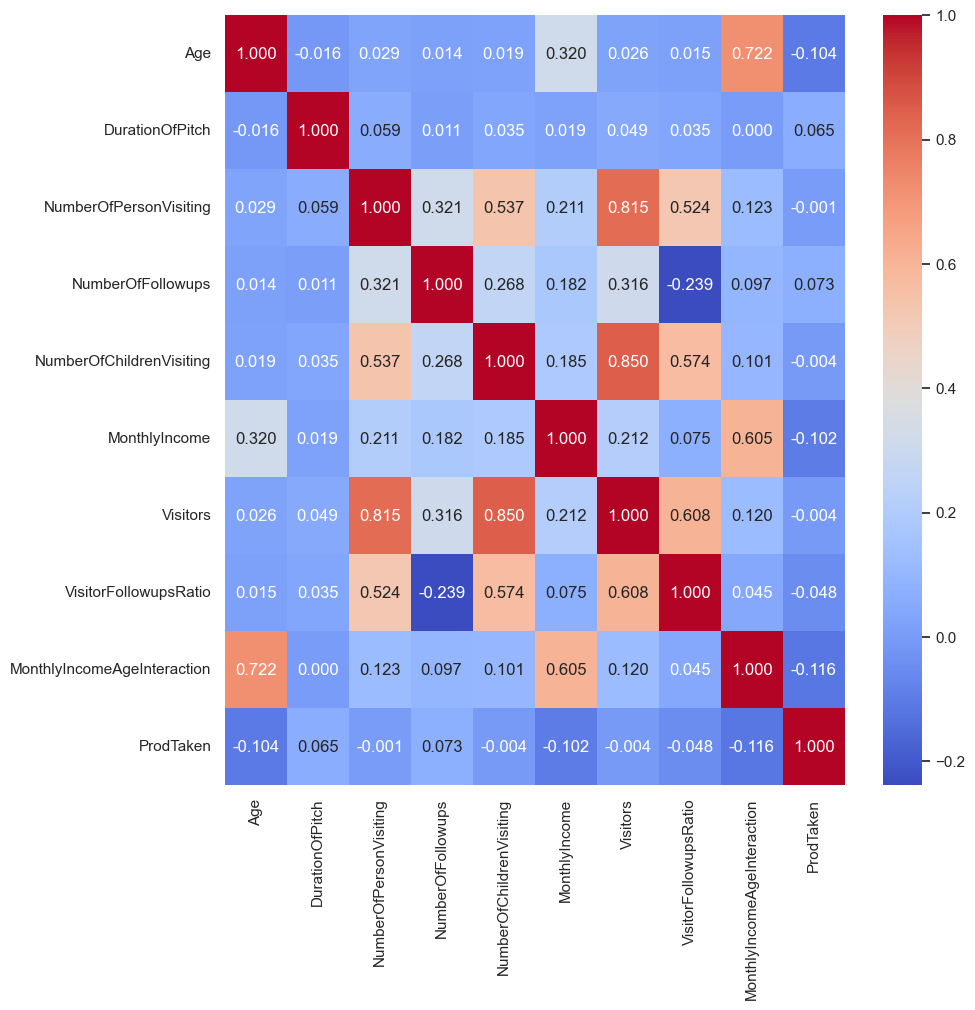

In [42]:
numerical_columns = [
    "Age",
    "DurationOfPitch",
    "NumberOfPersonVisiting",
    "NumberOfFollowups",
    "NumberOfChildrenVisiting",
    "MonthlyIncome",
    "Visitors",
    "VisitorFollowupsRatio",
    "MonthlyIncomeAgeInteraction",
]

plt.figure(figsize=(10, 10))

sns.heatmap(
    pd.concat([Xtrain[numerical_columns], ytrain], axis=1).corr(method="kendall"),
    annot=True,
    cmap="coolwarm",
    fmt=".3f",
)

Text(0.5, 1.0, "Cramer's V - Categorical Correlation")

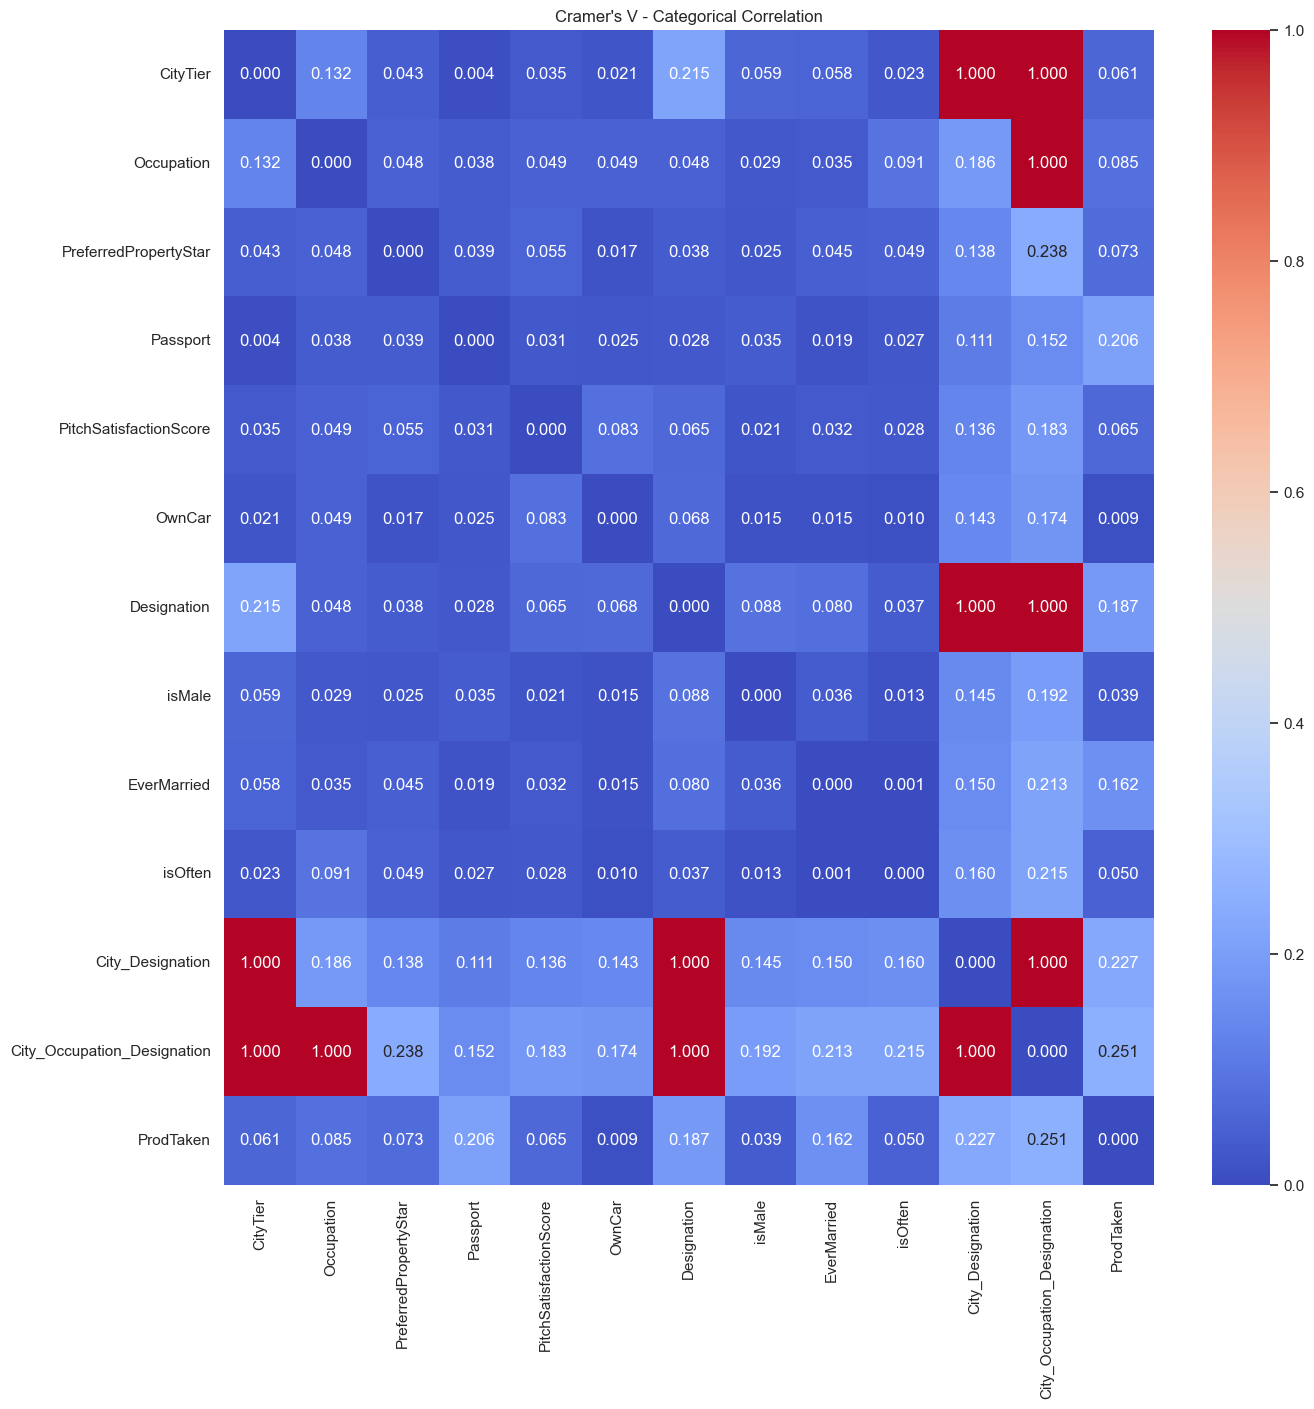

In [43]:
df_temp = pd.concat([Xtrain, ytrain], axis=1)

cat_col_target = [col for col in Xtrain.columns if col not in numerical_columns] + [
    target
]

cramers_v_matrix = np.zeros((len(cat_col_target), len(cat_col_target)))

for i in range(len(cat_col_target)):
    for j in range(i + 1, len(cat_col_target)):
        contingency_table = pd.crosstab(
            df_temp[cat_col_target[i]], df_temp[cat_col_target[j]]
        )
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        n = contingency_table.sum().sum()
        cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

        cramers_v_matrix[i, j] = cramers_v
        cramers_v_matrix[j, i] = cramers_v

cramers_v_df_temp = pd.DataFrame(
    cramers_v_matrix, index=cat_col_target, columns=cat_col_target
)

plt.figure(figsize=(15, 15))
sns.heatmap(
    cramers_v_df_temp,
    annot=True,
    cmap="coolwarm",
    fmt=".3f",
)

plt.title("Cramer's V - Categorical Correlation")

### Dropping

In [44]:
feats = [
    "Age",
    "PreferredPropertyStar",
    "Passport",
    "OwnCar",
    "Designation",
    "MonthlyIncome",
    "EverMarried",
    "isOften",
    "Visitors",
]
drop_feat = [feat for feat in Xtrain.columns if feat not in feats]

In [45]:
Xtrain.drop(drop_feat, axis=1, inplace=True)
Xtest.drop(drop_feat, axis=1, inplace=True)

## Feature Scaling

In [46]:
scaler = StandardScaler()

scaled_feats = ["Age", "MonthlyIncome", "Visitors"]

Xtrain[scaled_feats] = scaler.fit_transform(Xtrain[scaled_feats])
Xtest[scaled_feats] = scaler.transform(Xtest[scaled_feats])

## Class Imbalance Handling

In [47]:
Xtrain, ytrain = over_sampling.SMOTE(random_state=random_state).fit_resample(
    Xtrain, ytrain
)

# Stage 3

In [48]:
# The parameter will change per hyperparameter tuning
def create_model(kind):
    if kind == "AdaBoost":
        return AdaBoostClassifier(
            n_estimators=300,
            learning_rate=1e-1,
            estimator=DecisionTreeClassifier(random_state=random_state, max_depth=2),
            algorithm="SAMME.R",
            random_state=random_state,
        )
    elif kind == "GradientBoost":
        return GradientBoostingClassifier(
            n_estimators=300,
            max_depth=4,
            learning_rate=6e-3,
            subsample=0.5,
            n_iter_no_change=10,
            random_state=random_state,
        )
    elif kind == "LogReg":
        return LogisticRegression(
            random_state=random_state,
            C=1,
            class_weight="balanced",
            max_iter=50,
            penalty="l1",
            solver="liblinear",
        )
    elif kind == "DeepLearning":
        model = tf.keras.Sequential(
            [
                layers.Input(Xtrain.shape[1]),
                layers.Dense(128, activation="relu", kernel_regularizer=l2(0.003)),
                layers.Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
                # layers.Dropout(0.1),
                layers.Dense(32, activation="relu", kernel_regularizer=l2(0.00)),
                # layers.Dropout(0.1),
                layers.Dense(1, activation="sigmoid"),
            ]
        )

        model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss="binary_crossentropy",
            metrics=["accuracy", "Precision", "Recall"],
        )

        return model
    elif kind == "KNN":
        return KNeighborsClassifier(
            n_neighbors=40,
            metric="euclidean",
        )


def create_and_train_model(Xtrain, ytrain, Xtest, ytest):
    model = create_model("DeepLearning")
    early_stopping = EarlyStopping(
        monitor="recall",
        patience=7,
        mode="min",
    )
    model.fit(
        Xtrain,
        ytrain,
        epochs=1000,
        batch_size=512,
        validation_data=[Xtest, ytest],
        callbacks=[early_stopping],
        verbose=0,
    )
    return model

In [49]:
build_model = False
version = "final"
if ~build_model:
    !gdown 1g5k6sJNf8XnYc_8WwThQoChMTeJAKMZD
    !unzip final.zip
    abc = load(f"{version}/AdaBoostClassifier.joblib")
    gbc = load(f"{version}/GradientBoostClassifier.joblib")
    knn = load(f"{version}/KNearestNeighbors.joblib")
    lr = load(f"{version}/LogisticRegression.joblib")
    dl = tf.keras.models.load_model(f"{version}/DeepLearning.h5")

## Cross Validation

In [50]:
models = {
    "AdaBoostClassifier": create_model("AdaBoost"),
    "GradientBoostClassifier": create_model("GradientBoost"),
    "KNearestNeighbors": create_model("KNN"),
    "LogisticRegression": create_model("LogReg"),
}

X = Xtrain.copy()
y = ytrain.copy()

evaluasi = pd.DataFrame(
    {
        "model": [],
        "on": [],
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1-Score": [],
        "ROC": [],
    }
)

for m, model in models.items():
    cv_val = cross_validate(
        model, X, y, cv=5, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"]
    )
    evaluasi = pd.concat(
        [
            evaluasi,
            pd.DataFrame(
                {
                    "model": [m],
                    "on": ["cross val"],
                    "Accuracy": [cv_val["test_accuracy"].mean()],
                    "Precision": [cv_val["test_precision"].mean()],
                    "Recall": [cv_val["test_recall"].mean()],
                    "F1-Score": [cv_val["test_f1"].mean()],
                    "ROC": [cv_val["test_roc_auc"].mean()],
                }
            ),
        ]
    )

In [51]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
X = X.values
y = y.values

test_accuracy = []
test_precision = []
test_recall = []
test_f1 = []
test_roc_auc = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_and_train_model(X_train, y_train, X_test, y_test)

    y_pred = model.predict(X_test, verbose=0)
    y_pred = (y_pred > 0.5).astype(int)
    test_accuracy.append(accuracy_score(y_test, y_pred))
    test_precision.append(precision_score(y_test, y_pred, zero_division=0))
    test_recall.append(recall_score(y_test, y_pred, zero_division=0))
    test_f1.append(f1_score(y_test, y_pred, zero_division=0))
    test_roc_auc.append(roc_auc_score(y_test, y_pred))

evaluasi = pd.concat(
    [
        evaluasi,
        pd.DataFrame(
            {
                "model": ["DeepLearning"],
                "on": ["cross val"],
                "Accuracy": [np.mean(test_accuracy)],
                "Precision": [np.mean(test_precision)],
                "Recall": [np.mean(test_recall)],
                "F1-Score": [np.mean(test_f1)],
                "ROC": [np.mean(test_roc_auc)],
            }
        ),
    ]
)

## Building Model

In [52]:
if build_model:
    abc = create_model("AdaBoost")
    abc.fit(Xtrain, ytrain)

    gbc = create_model("GradientBoost")
    gbc.fit(Xtrain, ytrain)

    knn = create_model("KNN")
    knn.fit(Xtrain, ytrain)

    lr = create_model("LogReg")
    lr.fit(Xtrain, ytrain)

    dl = create_and_train_model(Xtrain, ytrain, Xtest, ytest)

In [53]:
models = {
    "AdaBoostClassifier": abc,
    "GradientBoostClassifier": gbc,
    "KNearestNeighbors": knn,
    "LogisticRegression": lr,
    "DeepLearning": dl,
}

for m, model in models.items():
    if m != "DeepLearning":
        y_pred = model.predict_proba(Xtrain)
        y_pred = (y_pred[:, 1] >= 0.5).astype(int)
    else:
        y_pred = model.predict(Xtrain, verbose=0)
        y_pred = (y_pred >= 0.5).astype(int)
    train_accuracy = accuracy_score(ytrain, y_pred)
    train_precision = precision_score(ytrain, y_pred, zero_division=0)
    train_recall = recall_score(ytrain, y_pred, zero_division=0)
    train_f1 = f1_score(ytrain, y_pred, zero_division=0)
    train_roc_auc = roc_auc_score(ytrain, y_pred)
    evaluasi = pd.concat(
        [
            evaluasi,
            pd.DataFrame(
                {
                    "model": [m],
                    "on": ["train"],
                    "Accuracy": [train_accuracy],
                    "Precision": [train_precision],
                    "Recall": [train_recall],
                    "F1-Score": [train_f1],
                    "ROC": [train_roc_auc],
                }
            ),
        ]
    )

    if m != "DeepLearning":
        y_pred = model.predict_proba(Xtest)
        y_pred = (y_pred[:, 1] >= 0.5).astype(int)
    else:
        y_pred = model.predict(Xtest, verbose=0)
        y_pred = (y_pred >= 0.5).astype(int)
    y_pred = (y_pred > 0.5).astype(int)
    test_accuracy = accuracy_score(ytest, y_pred)
    test_precision = precision_score(ytest, y_pred, zero_division=0)
    test_recall = recall_score(ytest, y_pred, zero_division=0)
    test_f1 = f1_score(ytest, y_pred, zero_division=0)
    test_roc_auc = roc_auc_score(ytest, y_pred)
    evaluasi = pd.concat(
        [
            evaluasi,
            pd.DataFrame(
                {
                    "model": [m],
                    "on": ["test"],
                    "Accuracy": [test_accuracy],
                    "Precision": [test_precision],
                    "Recall": [test_recall],
                    "F1-Score": [test_f1],
                    "ROC": [test_roc_auc],
                }
            ),
        ]
    )

evaluasi

,model,on,Accuracy,Precision,Recall,F1-Score,ROC
0,AdaBoostClassifier,cross val,0.899245,0.954817,0.840243,0.881649,0.956743
0,GradientBoostClassifier,cross val,0.788086,0.802804,0.763323,0.782283,0.860753
0,KNearestNeighbors,cross val,0.783044,0.758053,0.832428,0.793366,0.861460
0,LogisticRegression,cross val,0.683272,0.674951,0.707457,0.690727,0.737388
0,DeepLearning,cross val,0.724449,0.749079,0.676351,0.710539,0.724444
0,AdaBoostClassifier,train,0.928592,0.968229,0.886265,0.925436,0.928592
0,AdaBoostClassifier,test,0.647239,0.928571,0.319018,0.474886,0.647239
0,GradientBoostClassifier,train,0.799741,0.824299,0.761877,0.791860,0.799741
0,GradientBoostClassifier,test,0.743354,0.811518,0.633947,0.711825,0.743354
0,KNearestNeighbors,train,0.819177,0.778588,0.892024,0.831455,0.819177


## Evaluate

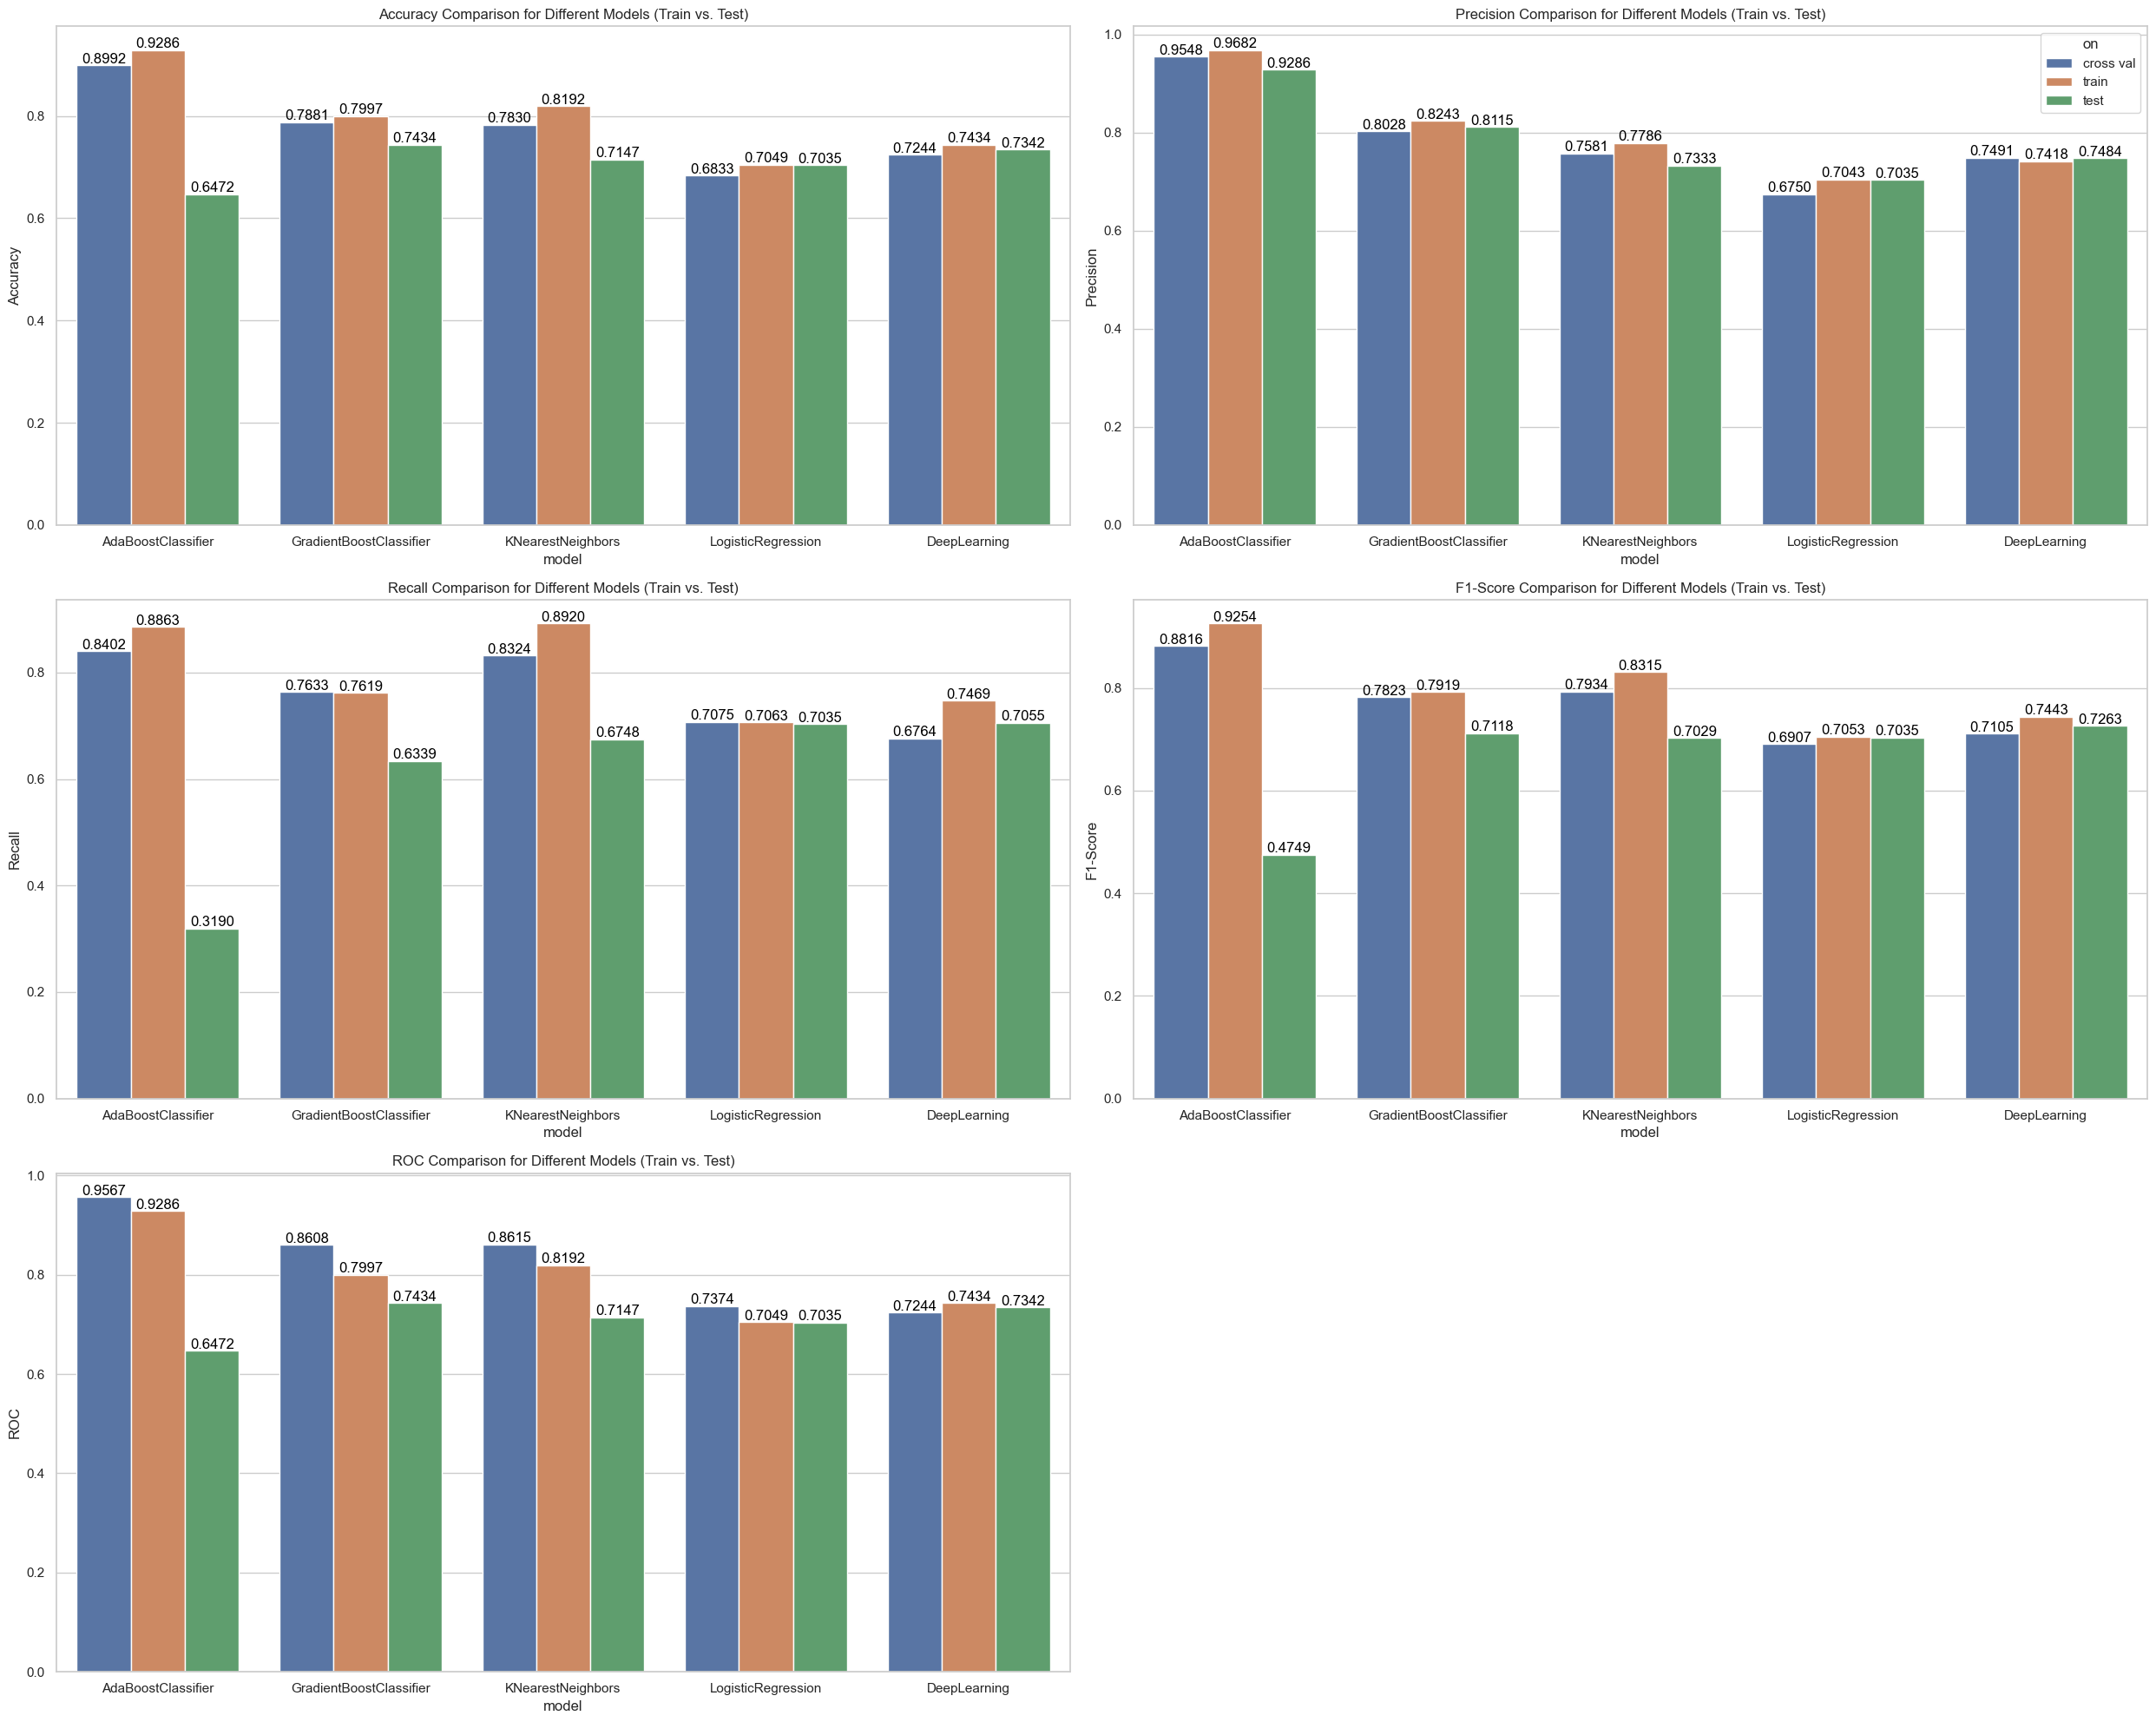

In [54]:
plt.figure(figsize=(25, 20))
plt.subplot(321)
sns.barplot(evaluasi, x="model", y="Accuracy", hue="on")
ax = plt.gca()
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.4f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=12,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )
plt.title("Accuracy Comparison for Different Models (Train vs. Test)")
ax.legend().set_visible(False)

plt.subplot(322)
sns.barplot(evaluasi, x="model", y="Precision", hue="on")
ax = plt.gca()
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.4f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=12,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )
plt.title("Precision Comparison for Different Models (Train vs. Test)")

plt.subplot(323)
sns.barplot(evaluasi, x="model", y="Recall", hue="on")
ax = plt.gca()
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.4f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=12,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )
plt.title("Recall Comparison for Different Models (Train vs. Test)")
ax.legend().set_visible(False)

plt.subplot(324)
sns.barplot(evaluasi, x="model", y="F1-Score", hue="on")
ax = plt.gca()
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.4f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=12,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )
plt.title("F1-Score Comparison for Different Models (Train vs. Test)")
ax.legend().set_visible(False)

plt.subplot(325)
sns.barplot(evaluasi, x="model", y="ROC", hue="on")
ax = plt.gca()
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.4f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=12,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )
plt.title("ROC Comparison for Different Models (Train vs. Test)")
ax.legend().set_visible(False)

plt.tight_layout()

simpan = False

if simpan:
    # !mkdir {version}
    plt.savefig(f"{version}/evaluasi.png")
    evaluasi.to_csv(f"{version}/log.csv", index=None)
    for m, model in models.items():
        dump(model, f"{version}/{m}.joblib")

    dl.save(f"{version}/DeepLearning.h5")
    dl.save(f"{version}/DeepLearning.keras")
    # !zip -r {version}.zip {version}/

In [55]:
models = {"LogisticRegression": lr, "DeepLearning": dl}

evaluasi2 = pd.DataFrame(
    {
        "model": [],
        "threshold": [],
        "on": [],
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1-Score": [],
        "ROC": [],
    }
)

threshold = np.linspace(0.3, 0.7, 36)
for m, model in models.items():
    for th in threshold:
        train_accuracy = []
        train_precision = []
        train_recall = []
        train_f1 = []
        train_roc_auc = []
        if m != "DeepLearning":
            y_pred = model.predict_proba(Xtrain)
            y_pred = (y_pred[:, 1] >= th).astype(int)
        else:
            y_pred = model.predict(Xtrain, verbose=0)
            y_pred = (y_pred >= th).astype(int)
        train_accuracy = accuracy_score(ytrain, y_pred)
        train_precision = precision_score(ytrain, y_pred, zero_division=0)
        train_recall = recall_score(ytrain, y_pred, zero_division=0)
        train_f1 = f1_score(ytrain, y_pred, zero_division=0)
        train_roc_auc = roc_auc_score(ytrain, y_pred)
        evaluasi2 = pd.concat(
            [
                evaluasi2,
                pd.DataFrame(
                    {
                        "model": [m],
                        "threshold": [th],
                        "on": ["train"],
                        "Accuracy": [train_accuracy],
                        "Precision": [train_precision],
                        "Recall": [train_recall],
                        "F1-Score": [train_f1],
                        "ROC": [train_roc_auc],
                    }
                ),
            ]
        )

        if m != "DeepLearning":
            y_pred = model.predict_proba(Xtest)
            y_pred = (y_pred[:, 1] >= th).astype(int)
        else:
            y_pred = model.predict(Xtest, verbose=0)
            y_pred = (y_pred >= th).astype(int)
        test_accuracy = accuracy_score(ytest, y_pred)
        test_precision = precision_score(ytest, y_pred, zero_division=0)
        test_recall = recall_score(ytest, y_pred, zero_division=0)
        test_f1 = f1_score(ytest, y_pred, zero_division=0)
        test_roc_auc = roc_auc_score(ytest, y_pred)
        evaluasi2 = pd.concat(
            [
                evaluasi2,
                pd.DataFrame(
                    {
                        "model": [m],
                        "threshold": [th],
                        "on": ["test"],
                        "Accuracy": [test_accuracy],
                        "Precision": [test_precision],
                        "Recall": [test_recall],
                        "F1-Score": [test_f1],
                        "ROC": [test_roc_auc],
                    }
                ),
            ]
        )

evaluasi2

,model,threshold,on,Accuracy,Precision,Recall,F1-Score,ROC
0,LogisticRegression,0.300000,train,0.617622,0.578212,0.869565,0.694572,0.617622
0,LogisticRegression,0.300000,test,0.622699,0.581744,0.873211,0.698283,0.622699
0,LogisticRegression,0.311429,train,0.626692,0.585670,0.866110,0.698804,0.626692
0,LogisticRegression,0.311429,test,0.632924,0.590278,0.869121,0.703060,0.632924
0,LogisticRegression,0.322857,train,0.635474,0.593298,0.861503,0.702677,0.635474
...,...,...,...,...,...,...,...,...
0,DeepLearning,0.677143,test,0.710634,0.834416,0.525562,0.644918,0.710634
0,DeepLearning,0.688571,train,0.722574,0.830342,0.559459,0.668502,0.722574
0,DeepLearning,0.688571,test,0.707566,0.834983,0.517382,0.638889,0.707566
0,DeepLearning,0.700000,train,0.718975,0.835465,0.545350,0.659930,0.718975


In [56]:
evaluasi2[(evaluasi2["Precision"] >= 0.8)].groupby(["model", "threshold", "on"]).agg(
    "mean"
)

Accuracy  Precision    Recall  F1-Score  \
model              threshold on                                               
DeepLearning       0.574286  test   0.745399   0.801508  0.652352  0.719278   
                   0.585714  test   0.742331   0.801527  0.644172  0.714286   
                   0.597143  test   0.742331   0.809399  0.633947  0.711009   
                   0.608571  test   0.741309   0.813830  0.625767  0.707514   
                   0.620000  test   0.735174   0.814208  0.609407  0.697076   
                   0.631429  test   0.734151   0.820728  0.599182  0.692671   
                             train  0.733804   0.802759  0.619925  0.699594   
                   0.642857  test   0.728016   0.826979  0.576687  0.679518   
                             train  0.733804   0.809924  0.610999  0.696537   
                   0.654286  test   0.728016   0.834835  0.568507  0.676399   
                             train  0.730060   0.812843  0.597754  0.688900   
                   0.665714  test   0.717791   0.833856  0.543967  0.658416   
                             train  0.730204   0.821730  0.587964  0.685465   
                   0.677143  test   0.710634   0.834416  0.525562  0.644918   
                             train  0.727613   0.826248  0.576447  0.679104   
                   0.688571  test   0.707566   0.834983  0.517382  0.638889   
                             train  0.722574   0.830342  0.559459  0.668502   
                   0.700000  test   0.702454   0.839041  0.501022  0.627401   
                             train  0.718975   0.835465  0.545350  0.659930   
LogisticRegression 0.620000  test   0.712679   0.813253  0.552147  0.657734   
                   0.631429  test   0.709611   0.827476  0.529652  0.645885   
                             train  0.716671   0.803795  0.573280  0.669244   
                   0.642857  test   0.702454   0.839041  0.501022  0.627401   
                             train  0.717967   0.819140  0.559459  0.664842   
                   0.654286  test   0.695297   0.842294  0.480573  0.611979   
                             train  0.714080   0.828837  0.539591  0.653645   
                   0.665714  test   0.685072   0.844106  0.453988  0.590426   
                             train  0.706162   0.839981  0.509358  0.634164   
                   0.677143  test   0.678937   0.851406  0.433538  0.574526   
                             train  0.692629   0.844845  0.471926  0.605579   
                   0.688571  test   0.671779   0.868421  0.404908  0.552301   
                             train  0.676073   0.850029  0.427584  0.568966   
                   0.700000  test   0.660532   0.865116  0.380368  0.528409   
                             train  0.655053   0.848544  0.377483  0.522519   

                                         ROC  
model              threshold on               
DeepLearning       0.574286  test   0.745399  
                   0.585714  test   0.742331  
                   0.597143  test   0.742331  
                   0.608571  test   0.741309  
                   0.620000  test   0.735174  
                   0.631429  test   0.734151  
                             train  0.733804  
                   0.642857  test   0.728016  
                             train  0.733804  
                   0.654286  test   0.728016  
                             train  0.730060  
                   0.665714  test   0.717791  
                             train  0.730204  
                   0.677143  test   0.710634  
                             train  0.727613  
                   0.688571  test   0.707566  
                             train  0.722574  
                   0.700000  test   0.702454  
                             train  0.718975  
LogisticRegression 0.620000  test   0.712679  
                   0.631429  test   0.709611  
                             train  0.716671  
                   0.642857  test   0.702454  
                

In [57]:
evaluasi3 = pd.DataFrame(
    {
        "model": [],
        "on": [],
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1-Score": [],
        "ROC": [],
    }
)

for m, model in models.items():
    if m == "LogisticRegression":
        th = 0.688571
    else:
        th = 0.631429
    if m != "DeepLearning":
        y_pred = model.predict_proba(Xtrain)
        y_pred = (y_pred[:, 1] >= th).astype(int)
    else:
        y_pred = model.predict(Xtrain, verbose=0)
        y_pred = (y_pred >= th).astype(int)
    train_accuracy = accuracy_score(ytrain, y_pred)
    train_precision = precision_score(ytrain, y_pred, zero_division=0)
    train_recall = recall_score(ytrain, y_pred, zero_division=0)
    train_f1 = f1_score(ytrain, y_pred, zero_division=0)
    train_roc_auc = roc_auc_score(ytrain, y_pred)
    evaluasi3 = pd.concat(
        [
            evaluasi3,
            pd.DataFrame(
                {
                    "model": [m],
                    "on": ["train"],
                    "Accuracy": [train_accuracy],
                    "Precision": [train_precision],
                    "Recall": [train_recall],
                    "F1-Score": [train_f1],
                    "ROC": [train_roc_auc],
                }
            ),
        ]
    )

    if m != "DeepLearning":
        y_pred = model.predict_proba(Xtest)
        y_pred = (y_pred[:, 1] >= th).astype(int)
    else:
        y_pred = model.predict(Xtest, verbose=0)
        y_pred = (y_pred >= th).astype(int)
    test_accuracy = accuracy_score(ytest, y_pred)
    test_precision = precision_score(ytest, y_pred, zero_division=0)
    test_recall = recall_score(ytest, y_pred, zero_division=0)
    test_f1 = f1_score(ytest, y_pred, zero_division=0)
    test_roc_auc = roc_auc_score(ytest, y_pred)
    evaluasi3 = pd.concat(
        [
            evaluasi3,
            pd.DataFrame(
                {
                    "model": [m],
                    "on": ["test"],
                    "Accuracy": [test_accuracy],
                    "Precision": [test_precision],
                    "Recall": [test_recall],
                    "F1-Score": [test_f1],
                    "ROC": [test_roc_auc],
                }
            ),
        ]
    )

evaluasi3

,model,on,Accuracy,Precision,Recall,F1-Score,ROC
0,LogisticRegression,train,0.676073,0.850029,0.427584,0.568966,0.676073
0,LogisticRegression,test,0.671779,0.868421,0.404908,0.552301,0.671779
0,DeepLearning,train,0.733804,0.802759,0.619925,0.699594,0.733804
0,DeepLearning,test,0.734151,0.820728,0.599182,0.692671,0.734151


In [58]:
def model_predict(X):
    ypred = dl.predict(X, verbose=0)
    ypred = (ypred >= 0.631429).astype(int)
    return ypred


ye = model_predict(Xtest)
tn, fp, fn, tp = confusion_matrix(ytest, ye).ravel()
tn, fp, fn, tp

(425, 64, 196, 293)

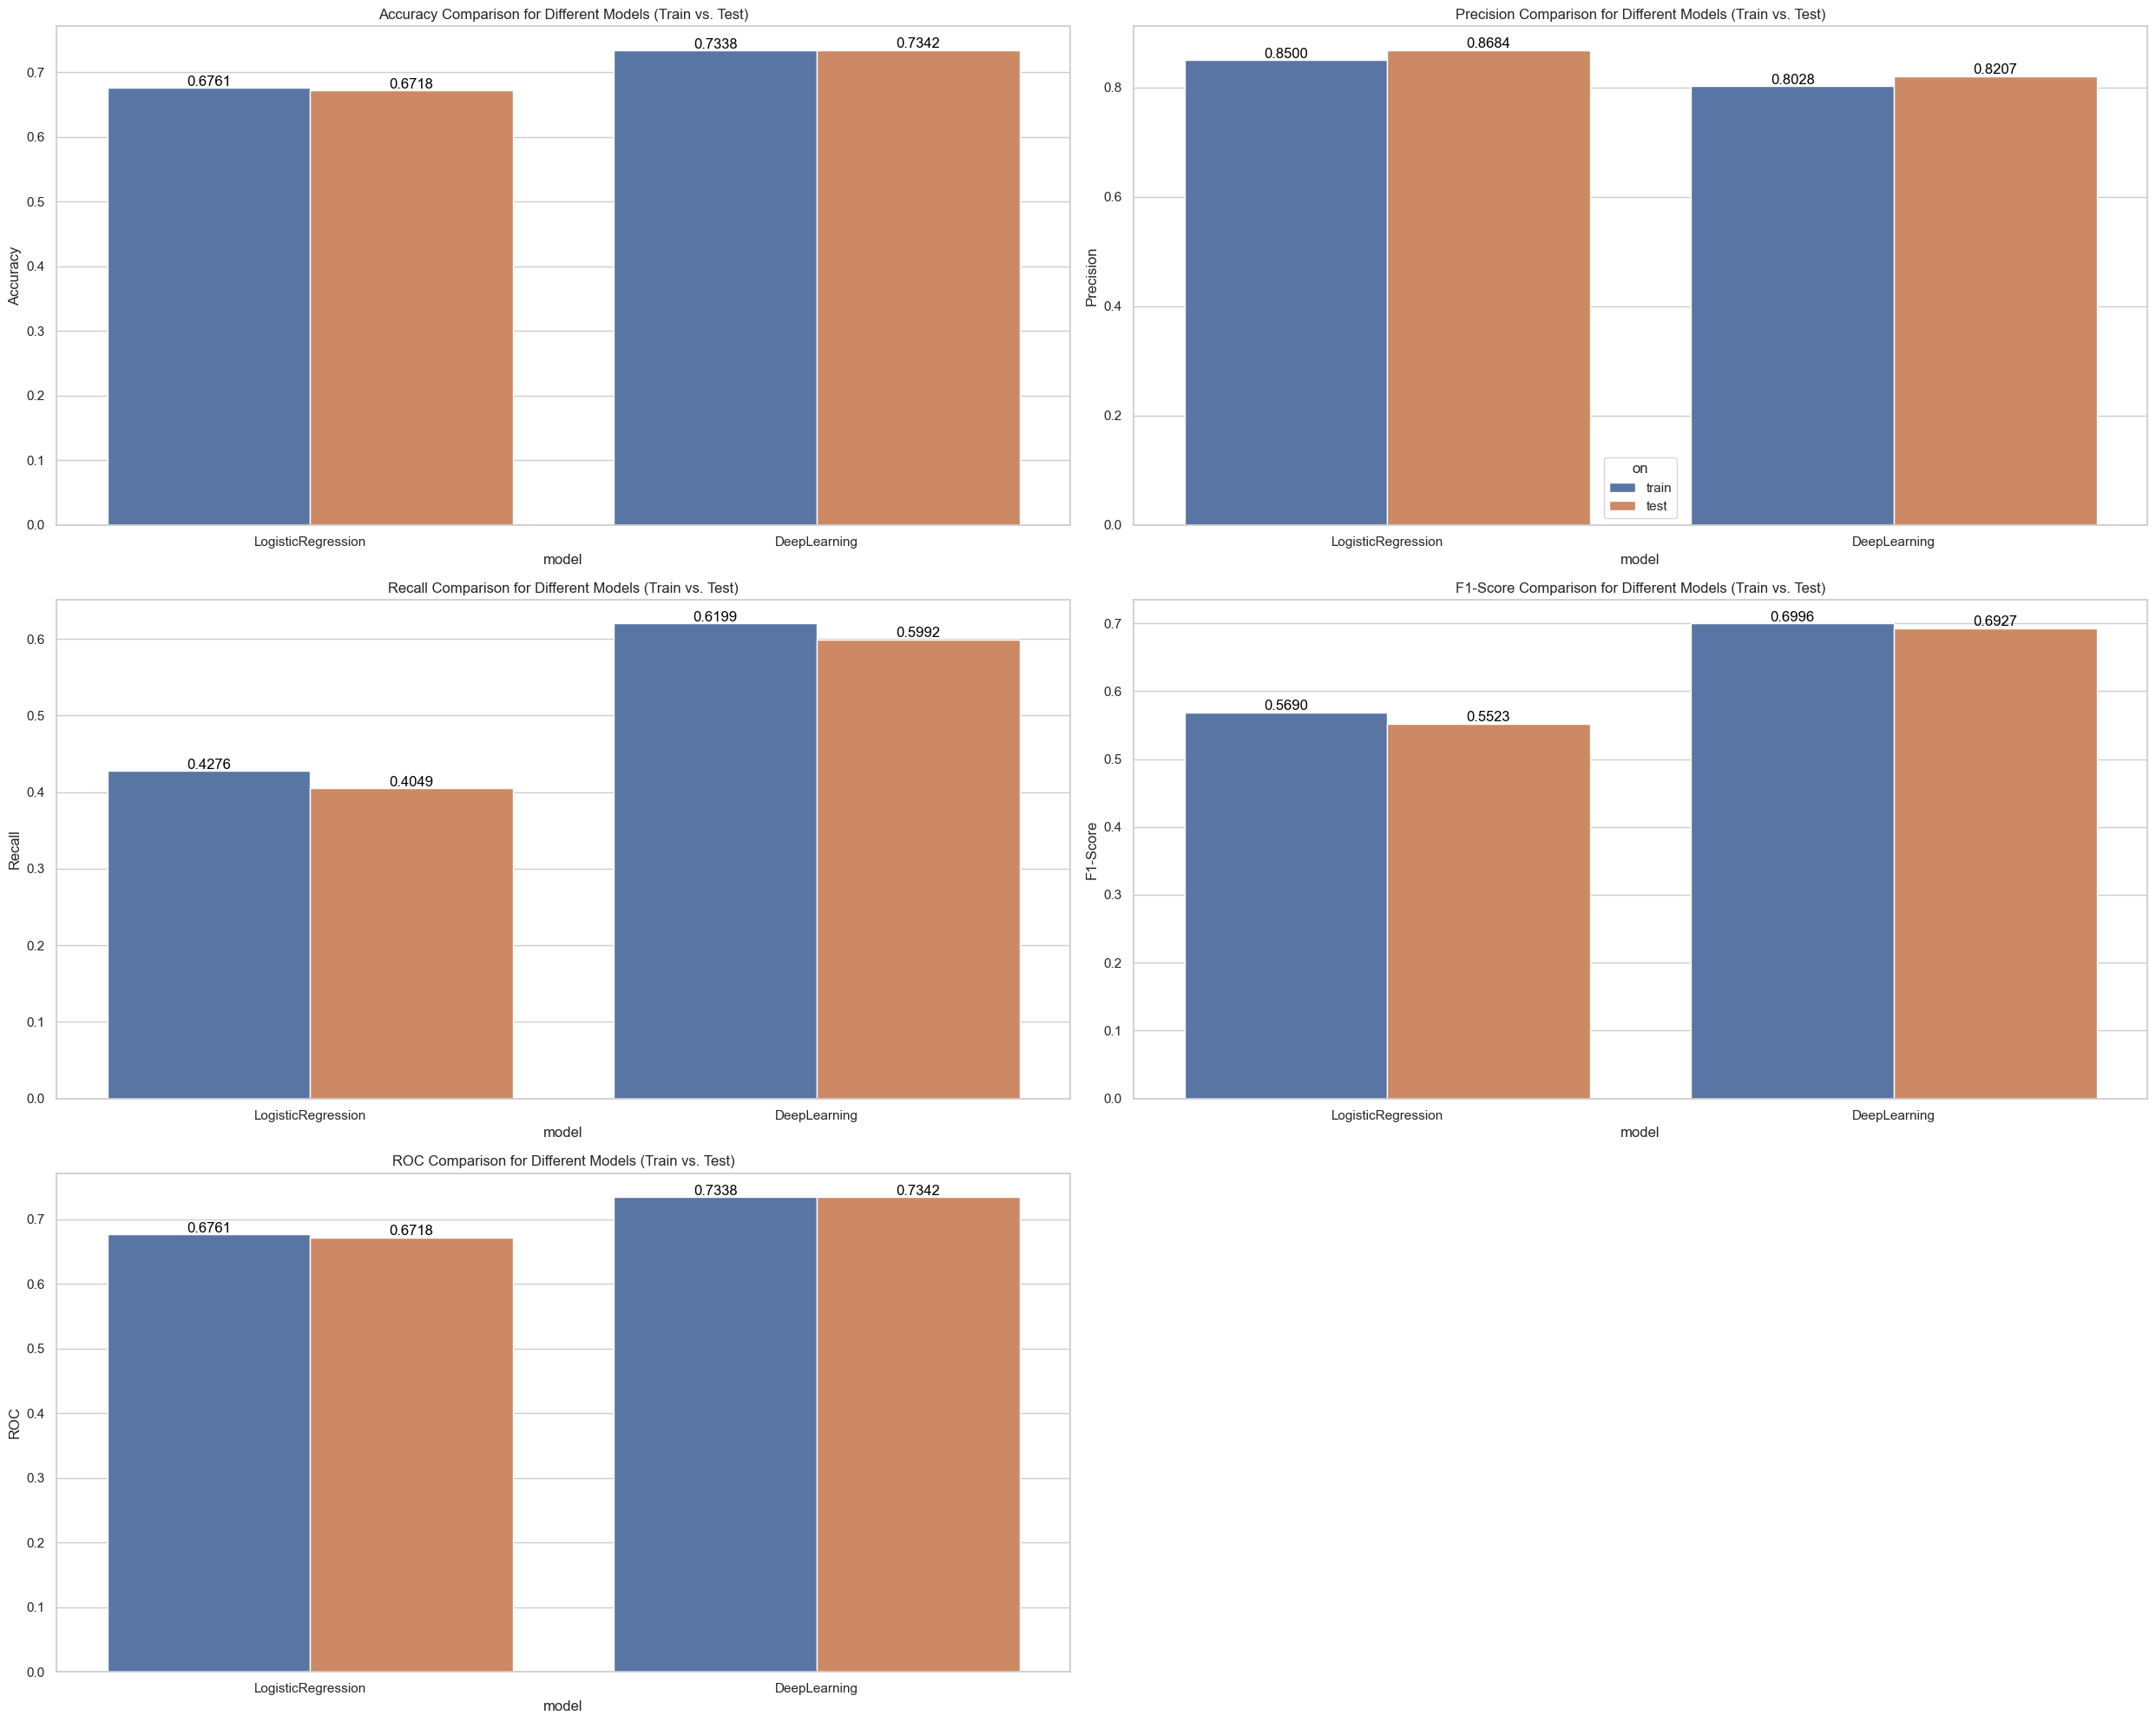

In [59]:
plt.figure(figsize=(25, 20))
plt.subplot(321)
sns.barplot(evaluasi3, x="model", y="Accuracy", hue="on")
ax = plt.gca()
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.4f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=12,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )
plt.title("Accuracy Comparison for Different Models (Train vs. Test)")
ax.legend().set_visible(False)

plt.subplot(322)
sns.barplot(evaluasi3, x="model", y="Precision", hue="on")
ax = plt.gca()
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.4f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=12,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )
plt.title("Precision Comparison for Different Models (Train vs. Test)")

plt.subplot(323)
sns.barplot(evaluasi3, x="model", y="Recall", hue="on")
ax = plt.gca()
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.4f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=12,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )
plt.title("Recall Comparison for Different Models (Train vs. Test)")
ax.legend().set_visible(False)

plt.subplot(324)
sns.barplot(evaluasi3, x="model", y="F1-Score", hue="on")
ax = plt.gca()
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.4f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=12,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )
plt.title("F1-Score Comparison for Different Models (Train vs. Test)")
ax.legend().set_visible(False)

plt.subplot(325)
sns.barplot(evaluasi3, x="model", y="ROC", hue="on")
ax = plt.gca()
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.4f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        fontsize=12,
        color="black",
        xytext=(0, 5),
        textcoords="offset points",
    )
plt.title("ROC Comparison for Different Models (Train vs. Test)")
ax.legend().set_visible(False)

plt.tight_layout()

# Feature importance

Exact explainer: 979it [27:16,  1.68s/it]                         


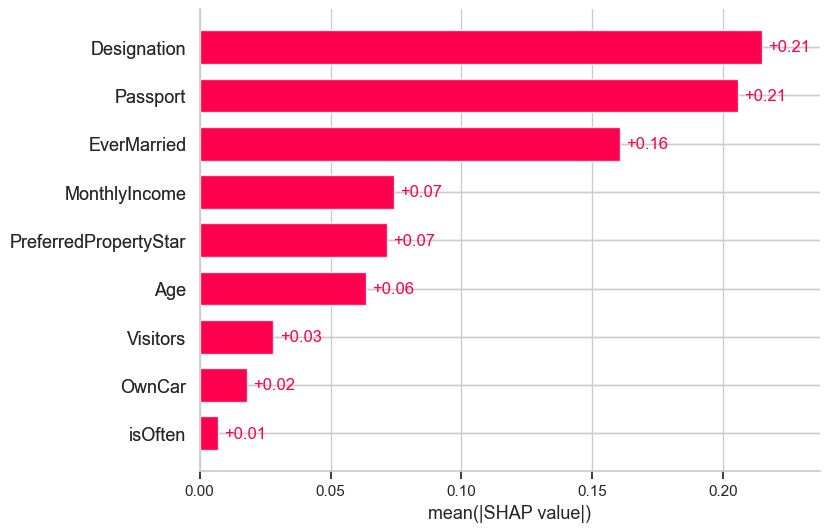

In [60]:
background_data = shap.sample(Xtrain, 200)
explainer = shap.Explainer(model_predict, background_data)
shap_values = explainer(Xtest)
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


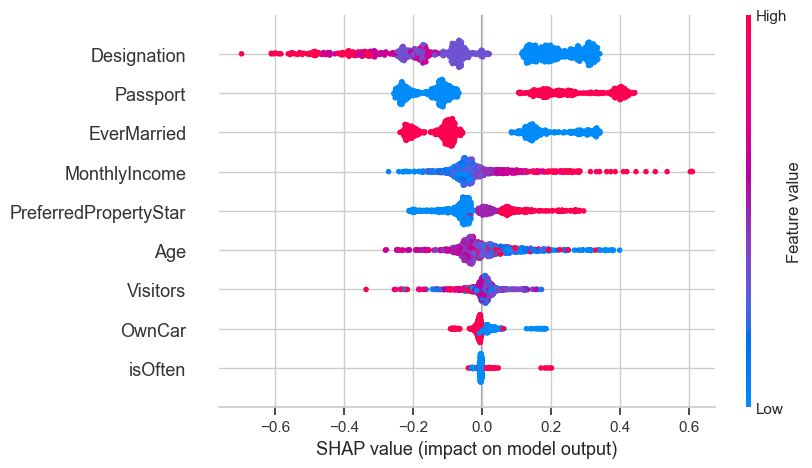

In [61]:
shap.plots.beeswarm(shap_values)

## Business Insight & Action Items

Passport adalah fiture dengan nilai feature importance yang paling tinggi, diikuti oleh marital status (EverMarried) dan Designation, dimana fitur-fitur tersebut memiliki korelasi dengan kecenderungan customer mengambil produk yang tawarkan. Pelanggan yang memiliki passport dan belum pernah menikah lebih cenderung mengambil paket liburan. Customer yang single dan unmarried lebih cenderung mengambil produk yang ditawarkan, mungkin dikarenakan customer yang belum berpasangan  lebih  bebas dalam membuat keputusan.
- Saat ini, perusahaan hanya memfokuskan produk tertentu kepada pelanggan dengan jabatan tertentu. Perusahaan seharusnya tidak hanya terpaku pada jabatan saja, melainkan fokus kepada pendekatan yang lebih terarah, seperti menargetkan pelanggan yang mempunyai passport dan belum pernah menikah karena faktor-faktor inilah yang dapat lebih mempengaruhi keputusan pelanggan.
- Perusahaan juga bisa mendahulukan promosi kepada pelanggan yang memilih hotel dengan bintang paling tinggi
- Lakukan pitching dengan durasi sekitar 20 menit
- Maksimalkan jumlah tindak lanjut